#Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode
from scipy.io import loadmat
from math import *
from sklearn.metrics import confusion_matrix
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix

# Load data


In [2]:
latent_states = np.load('latentStates.npz')
inferredStates = latent_states['inferredStates']
unique_states = np.load('uniqueStates.npz')
obs_keys = np.load('obsKeys.npz')
features = np.load('natural_props_all_healthy_features.npy')

uniqueStates = unique_states['uniqueStates']
obsKeys = obs_keys['obsKeys']

manualStates = inferredStates[:, 1]
latentStates = inferredStates[:, 0]

nLS = uniqueStates.shape[0]
LS = [f"LS-{i+1}" for i in range(nLS)]

In [3]:
majority_inferred_states = []
Wake_pct = []
NREM_pct = []
REM_pct = []

# Iterate through each unique state in the training data
for i in uniqueStates[:, 0]:
# Find indices where the second column of obsKeys matches the current unique state
        idx = np.where(obsKeys[:, 1] == i)[0]

        # Extract frames corresponding to the current latent state
        latent_frames = obsKeys[idx, :]

        # Calculate the proportion of each state (awake, nrem, rem) in the latent frames
        awake_pct = round(len(np.where(latent_frames[:, 3] == 1)[0]) / float(len(latent_frames)), 3)
        nrem_pct = round(len(np.where(latent_frames[:, 3] == 3)[0]) / float(len(latent_frames)), 3)
        rem_pct = round(len(np.where(latent_frames[:, 3] == 5)[0]) / float(len(latent_frames)), 3)

        Wake_pct.append(awake_pct)
        NREM_pct.append(nrem_pct)
        REM_pct.append(rem_pct)

        # Determine the majority state based on the proportions and append to the list
        if awake_pct >= nrem_pct and awake_pct >= rem_pct:
            majority_inferred_states.append(1)
        elif nrem_pct >= rem_pct and nrem_pct >= awake_pct:
            majority_inferred_states.append(3)
        elif rem_pct >= nrem_pct and rem_pct >= awake_pct:
            majority_inferred_states.append(5)


In [4]:
num_latent_states = np.max(inferredStates[:,0])

In [5]:
average_features_per_ls = np.empty((len(uniqueStates[:,0]),10))
for i in range(1,len(uniqueStates[:,0])+1):
    mean_features = np.mean(features[np.where(inferredStates[:,0]==i)[0]], axis = 0)
    average_features_per_ls[i-1] = mean_features

In [6]:
average_feature_Wake_ls = np.copy(average_features_per_ls)
average_feature_NREM_ls = np.copy(average_features_per_ls)
average_feature_REM_ls = np.copy(average_features_per_ls)

a = np.where(np.array(majority_inferred_states) != 1)[0]
b = np.where(np.array(majority_inferred_states) != 3)[0]
c = np.where(np.array(majority_inferred_states) != 5)[0]

average_feature_Wake_ls[a] = np.zeros(10)
average_feature_NREM_ls[b] = np.zeros(10)
average_feature_REM_ls[c] = np.zeros(10)

In [7]:
inferred_states = np.zeros(len(inferredStates))
for i in np.unique(inferredStates[:,0]):
  state = majority_inferred_states[int(i-1)]
  inferred_states[np.where(inferredStates[:,0] == i)[0]] = state

In [8]:
wakenum = len(np.where(inferred_states == 1)[0])
nremnum = len(np.where(inferred_states == 3)[0])
remnum = len(np.where(inferred_states == 5)[0])

In [9]:
prop = 0.07    # A latent state should contain at least 'prop' (5) percent of the epochs from an inferred state to be considered as a substate

In [10]:
print('How many epochs in a latent state for it to be considered large? : ')
print('')
print('Num of inferred Wake: ', wakenum, '=> at least ', wakenum*prop, 'epochs')
print('Num of inferred NREM: ', nremnum, '=> at least ', nremnum*prop, 'epochs')
print('Num of inferred REM: ', remnum, '=> at least ', remnum*prop, 'epochs')

How many epochs in a latent state for it to be considered large? : 

Num of inferred Wake:  310258 => at least  21718.06 epochs
Num of inferred NREM:  243160 => at least  17021.2 epochs
Num of inferred REM:  54682 => at least  3827.7400000000002 epochs


---
---
# Clustering small latent states with larger ones by similarity and state-wise (rem only joins rem...)

In this section, you can choose for each state the minimum amount of epochs in a latent state for it to be deemed large (minimun proportion of all epochs in the given state). Smaller latent states for each state will be mapped and combined to the nearest large latent state in the same state (euclidean distance).

In [11]:
#@title REM clustering
state_lengths = [len(np.where(inferredStates[:, 0] == state+1)[0]) for state in uniqueStates[:, 0]]
REM_large_thresh = 0.10*remnum

small_states = [i for i, length in enumerate(state_lengths) if length < REM_large_thresh]
large_states = [i for i, length in enumerate(state_lengths) if length >= REM_large_thresh]

large_REM_states = []
for i in large_states:
  if i in np.where(np.array(majority_inferred_states) == 5)[0]:
        large_REM_states.append(i)

print('Number or final REM clusters = ', len(large_REM_states))
print(large_REM_states)
print('')

REM_mapping = {}

# Iterate over each small latent state
for i in small_states:
  if majority_inferred_states[i] == 5:
    # Calculate distances from this small state to all large states
    distances = cdist([average_features_per_ls[i]], [average_features_per_ls[k] for k in large_REM_states], metric='euclidean')
    # Find the index of the closest large state
    closest_large_state_index = large_REM_states[np.argmin(distances)]
    # Map small state to the closest large state
    REM_mapping[i] = closest_large_state_index

# Output the mapping
print("Small to Large State Mapping:", REM_mapping)

Number or final REM clusters =  4
[82, 84, 87, 89]

Small to Large State Mapping: {23: 87, 24: 87, 83: 84, 85: 89, 86: 87, 88: 89, 98: 89}


In [12]:
#@title NREM clustering
state_lengths = [len(np.where(inferredStates[:, 0] == state+1)[0]) for state in uniqueStates[:, 0]]
NREM_large_thresh = prop*nremnum

small_states = [i for i, length in enumerate(state_lengths) if length < NREM_large_thresh]
large_states = [i for i, length in enumerate(state_lengths) if length >= NREM_large_thresh]

large_NREM_states = []
for i in large_states:
  if i in np.where(np.array(majority_inferred_states) == 3)[0]:
        large_NREM_states.append(i)

print('Number or final NREM clusters = ', len(large_NREM_states))
print(large_NREM_states)
print('')

NREM_mapping = {}

# Iterate over each small latent state
for i in small_states:
  if majority_inferred_states[i] == 3:
    # Calculate distances from this small state to all large states
    distances = cdist([average_features_per_ls[i]], [average_features_per_ls[k] for k in large_NREM_states], metric='euclidean')
    # Find the index of the closest large state
    closest_large_state_index = large_NREM_states[np.argmin(distances)]
    # Map small state to the closest large state
    NREM_mapping[i] = closest_large_state_index

# Output the mapping
print("Small to Large State Mapping:", NREM_mapping)

Number or final NREM clusters =  4
[12, 14, 18, 19]

Small to Large State Mapping: {3: 14, 4: 14, 5: 14, 9: 12, 10: 12, 11: 12, 13: 14, 15: 19, 16: 14, 17: 18, 20: 19, 26: 19, 27: 19, 28: 19, 29: 19, 58: 14, 64: 14, 70: 19, 72: 18, 74: 19, 75: 19, 76: 19, 97: 19, 99: 19, 100: 19, 101: 19}


In [13]:
#@title Wake clustering
state_lengths = [len(np.where(inferredStates[:, 0] == state+1)[0]) for state in uniqueStates[:, 0]]
Wake_large_thresh = 0.2*wakenum


small_states = [i for i, length in enumerate(state_lengths) if length < Wake_large_thresh]
large_states = [i for i, length in enumerate(state_lengths) if length >= Wake_large_thresh]

large_Wake_states = []
for i in large_states:
  if i in np.where(np.array(majority_inferred_states) == 1)[0]:
        large_Wake_states.append(i)

print('Number or final Wake clusters = ', len(large_Wake_states))
print(large_Wake_states)
print('')

Wake_mapping = {}

# Iterate over each small latent state
for i in small_states:
  if majority_inferred_states[i] == 1:
    # Calculate distances from this small state to all large states
    distances = cdist([average_features_per_ls[i]], [average_features_per_ls[k] for k in large_Wake_states], metric='euclidean')
    # Find the index of the closest large state
    closest_large_state_index = large_Wake_states[np.argmin(distances)]
    # Map small state to the closest large state
    Wake_mapping[i] = closest_large_state_index

# Output the mapping
print("Small to Large State Mapping:", Wake_mapping)

Number or final Wake clusters =  1
[39]

Small to Large State Mapping: {0: 39, 1: 39, 2: 39, 6: 39, 7: 39, 8: 39, 21: 39, 22: 39, 25: 39, 30: 39, 31: 39, 32: 39, 33: 39, 34: 39, 35: 39, 36: 39, 37: 39, 38: 39, 40: 39, 41: 39, 42: 39, 43: 39, 44: 39, 45: 39, 46: 39, 47: 39, 48: 39, 49: 39, 50: 39, 51: 39, 52: 39, 53: 39, 54: 39, 55: 39, 56: 39, 57: 39, 59: 39, 60: 39, 61: 39, 62: 39, 63: 39, 65: 39, 66: 39, 67: 39, 68: 39, 69: 39, 71: 39, 73: 39, 77: 39, 78: 39, 79: 39, 80: 39, 81: 39, 90: 39, 91: 39, 92: 39, 93: 39, 94: 39, 95: 39, 96: 39}


## Computations

Here a computed a set of metrics to evaluate the performance of the classification after grouping the latent states. See result summary in results section.

In [14]:
inferredStates2 = np.copy(inferredStates)

for i in REM_mapping:
  inferredStates2[np.where(inferredStates[:,0] == i+1)[0],0] = REM_mapping[i]+1
for i in NREM_mapping:
  inferredStates2[np.where(inferredStates[:,0] == i+1)[0],0] = NREM_mapping[i]+1
for i in Wake_mapping:
  inferredStates2[np.where(inferredStates[:,0] == i+1)[0],0] = Wake_mapping[i]+1

In [15]:
for i in range(len(inferredStates2[:,0])):
  inferredStates2[i,0] = inferredStates2[i,0]-1

In [16]:
np.unique(inferredStates2[:,0])

array([12., 14., 18., 19., 39., 82., 84., 87., 89.])

In [17]:
Wake_pct = []
NREM_pct = []
REM_pct = []

# Iterate through each unique state in the training data
for i in np.unique(inferredStates2[:, 0]):

        idx = np.where(inferredStates2[:,0] == i)[0]

        # Calculate the proportion of each state (awake, nrem, rem) in the latent frames
        awake_pct = round(len(np.where(inferredStates2[idx, 1] == 1)[0]) / float(len(idx)), 3)
        nrem_pct = round(len(np.where(inferredStates2[idx, 1] == 3)[0]) / float(len(idx)), 3)
        rem_pct = round(len(np.where(inferredStates2[idx, 1] == 5)[0]) / float(len(idx)), 3)

        Wake_pct.append(awake_pct)
        NREM_pct.append(nrem_pct)
        REM_pct.append(rem_pct)

In [18]:
final_states = np.array(np.concatenate((large_Wake_states, large_NREM_states, large_REM_states)))

In [19]:
probabilities = np.stack((final_states, np.array(Wake_pct)*100, np.array(NREM_pct)*100, np.array(REM_pct)*100), axis = 1)
probabilities = probabilities[probabilities[:, 0].argsort()]
print(probabilities)

[[12.  20.6 77.4  0.1]
 [14.   4.7 94.2  0.3]
 [18.  13.4 79.5  2.3]
 [19.  80.5 13.1  1.5]
 [39.   3.1 95.2  0.1]
 [82.   7.8  1.3 73.7]
 [84.   3.5  0.2 88.4]
 [87.   2.3  9.2 56. ]
 [89.   1.3  1.4 80.6]]


In [20]:
no_ts2 = inferredStates2[(inferredStates2[:, 1] != 0) & (inferredStates2[:, 1] != 4)]

Wake_pct = []
NREM_pct = []
REM_pct = []

# Iterate through each unique state in the training data
for i in np.unique(no_ts2[:, 0]):

        idx = np.where(no_ts2[:,0] == i)[0]

        # Calculate the proportion of each state (awake, nrem, rem) in the latent frames
        awake_pct = round(len(np.where(no_ts2[idx, 1] == 1)[0]) / float(len(idx)), 3)
        nrem_pct = round(len(np.where(no_ts2[idx, 1] == 3)[0]) / float(len(idx)), 3)
        rem_pct = round(len(np.where(no_ts2[idx, 1] == 5)[0]) / float(len(idx)), 3)

        Wake_pct.append(awake_pct)
        NREM_pct.append(nrem_pct)
        REM_pct.append(rem_pct)

probabilities_no_ts = np.stack((final_states, np.array(Wake_pct)*100, np.array(NREM_pct)*100, np.array(REM_pct)*100), axis = 1)
probabilities_no_ts = probabilities_no_ts[probabilities_no_ts[:, 0].argsort()]
print(probabilities_no_ts)

[[12.  21.  78.9  0.1]
 [14.   4.8 94.9  0.3]
 [18.  14.1 83.5  2.4]
 [19.  84.7 13.7  1.6]
 [39.   3.1 96.7  0.1]
 [82.   9.4  1.6 89. ]
 [84.   3.8  0.2 95.9]
 [87.   3.4 13.6 83. ]
 [89.   1.5  1.7 96.7]]


In [21]:
inferred_states2 = np.zeros(len(inferredStates2))
for i in np.unique(inferredStates2[:,0]):
  state = majority_inferred_states[int(i-1)]
  inferred_states2[np.where(inferredStates2[:,0] == i)[0]] = state

In [22]:
#@title Number of latent states after clustering

print(len(NREM_pct), ' latent states after clustering')

9  latent states after clustering


In [23]:
#@title Calculate metrics function
def calculate_metrics(conf_matrix):
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)
    accuracy = (TP+TN) / np.sum(conf_matrix)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1_score, specificity

In [24]:
REM_latent_states_explicit = []

for i in large_REM_states:
    current = [i]
    for k in REM_mapping:
        if REM_mapping[k] == i:
            current.append(k)
    REM_latent_states_explicit.append(current)

NREM_latent_states_explicit = []

for i in large_NREM_states:
    current = [i]
    for k in NREM_mapping:
        if NREM_mapping[k] == i:
            current.append(k)
    NREM_latent_states_explicit.append(current)

Wake_latent_states_explicit = []

for i in large_Wake_states:
    current = [i]
    for k in Wake_mapping:
        if Wake_mapping[k] == i:
            current.append(k)
    Wake_latent_states_explicit.append(current)

groups = Wake_latent_states_explicit+NREM_latent_states_explicit+REM_latent_states_explicit

In [25]:
sizes = []
for i in np.unique(inferredStates2[:,0]):
  sizes.append(len(np.where(inferredStates2[:,0] == i)[0]))

sizes_no_ts = []
for i in np.unique(no_ts2[:,0]):
  sizes_no_ts.append(len(np.where(no_ts2[:,0] == i)[0]))

In [26]:
main_state = []
for i in probabilities[:,0]:
  if majority_inferred_states[int(i)] == 1:
    main_state.append('Wake')
  if majority_inferred_states[int(i)] == 3:
    main_state.append('NREM')
  if majority_inferred_states[int(i)] == 5:
    main_state.append('REM')

In [27]:
summary_df = pd.DataFrame(probabilities, columns=['Large state', 'Wake %', 'NREM %', 'REM %'])
summary_df['Sizes'] = sizes
summary_df['Main state'] = main_state
print('Summary of final latent states with ts and artefacts')
print(summary_df)
print('')
print('Groupings: ')
print(pd.DataFrame(groups))

summary_df_no_ts = pd.DataFrame(probabilities_no_ts, columns=['Large state', 'Wake %', 'NREM %', 'REM %'])
summary_df_no_ts['Sizes'] = sizes_no_ts
summary_df_no_ts['Main state'] = main_state
print('Summary of final latent states without artefacts and ts')
print(summary_df_no_ts)
print('')
print('Groupings: ')
print(pd.DataFrame(groups))

Summary of final latent states with ts and artefacts
   Large state  Wake %  NREM %  REM %   Sizes Main state
0         12.0    20.6    77.4    0.1   63111       NREM
1         14.0     4.7    94.2    0.3   48741       NREM
2         18.0    13.4    79.5    2.3   51091       NREM
3         19.0    80.5    13.1    1.5   80217       NREM
4         39.0     3.1    95.2    0.1  310258       Wake
5         82.0     7.8     1.3   73.7    8085        REM
6         84.0     3.5     0.2   88.4    6686        REM
7         87.0     2.3     9.2   56.0   19407        REM
8         89.0     1.3     1.4   80.6   20504        REM

Groupings: 
   0     1     2     3     4     5     6     7     8     9   ...    51    52  \
0  39   0.0   1.0   2.0   6.0   7.0   8.0  21.0  22.0  25.0  ...  79.0  80.0   
1  12   9.0  10.0  11.0   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
2  14   3.0   4.0   5.0  13.0  16.0  58.0  64.0   NaN   NaN  ...   NaN   NaN   
3  18  17.0  72.0   NaN   NaN   NaN   NaN   

---
---
---
# Results


In [28]:
#@title Final latent states with TS and artefact (Percentages don't add up to 100 because of presence of TS and artefacts)
print('Final latent state and their wake nrem and rem proportions')
print('')
print(summary_df)

Final latent state and their wake nrem and rem proportions

   Large state  Wake %  NREM %  REM %   Sizes Main state
0         12.0    20.6    77.4    0.1   63111       NREM
1         14.0     4.7    94.2    0.3   48741       NREM
2         18.0    13.4    79.5    2.3   51091       NREM
3         19.0    80.5    13.1    1.5   80217       NREM
4         39.0     3.1    95.2    0.1  310258       Wake
5         82.0     7.8     1.3   73.7    8085        REM
6         84.0     3.5     0.2   88.4    6686        REM
7         87.0     2.3     9.2   56.0   19407        REM
8         89.0     1.3     1.4   80.6   20504        REM


In [29]:
#@title Final latent states exccluding TS and artefact

print('Final latent state and their wake nrem and rem proportions')
print('')
print(summary_df_no_ts)

Final latent state and their wake nrem and rem proportions

   Large state  Wake %  NREM %  REM %   Sizes Main state
0         12.0    21.0    78.9    0.1   62142       NREM
1         14.0     4.8    94.9    0.3   47812       NREM
2         18.0    14.1    83.5    2.4   50685       NREM
3         19.0    84.7    13.7    1.6   76363       NREM
4         39.0     3.1    96.7    0.1  295002       Wake
5         82.0     9.4     1.6   89.0    6692        REM
6         84.0     3.8     0.2   95.9    6160        REM
7         87.0     3.4    13.6   83.0   13100        REM
8         89.0     1.5     1.7   96.7   17083        REM


In [30]:
#@title Groups
print('Groupings: ')
print(pd.DataFrame(groups))
pd.DataFrame(groups).to_csv('groupings.csv', index=False)

Groupings: 
   0     1     2     3     4     5     6     7     8     9   ...    51    52  \
0  39   0.0   1.0   2.0   6.0   7.0   8.0  21.0  22.0  25.0  ...  79.0  80.0   
1  12   9.0  10.0  11.0   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
2  14   3.0   4.0   5.0  13.0  16.0  58.0  64.0   NaN   NaN  ...   NaN   NaN   
3  18  17.0  72.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
4  19  15.0  20.0  26.0  27.0  28.0  29.0  70.0  74.0  75.0  ...   NaN   NaN   
5  82   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
6  84  83.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
7  87  23.0  24.0  86.0   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
8  89  85.0  88.0  98.0   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   

     53    54    55    56    57    58    59    60  
0  81.0  90.0  91.0  92.0  93.0  94.0  95.0  96.0  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN

In [31]:
#@title Confusion matrix
conf_matrix = confusion_matrix(inferredStates2[:,1], inferred_states2, labels=[1, 3, 5])

accuracy, precision, recall, f1_score, specificity = calculate_metrics(conf_matrix)
metrics = np.stack((accuracy, precision, recall, f1_score, specificity), axis=1)

conf_matrix = pd.DataFrame(conf_matrix, columns=['P Wake', 'P NREM', 'P REM'], index=['T Wake', 'T NREM', 'T REM'])
metrics = pd.DataFrame(metrics.T, columns=['Wake', 'NREM', 'REM'], index=['Accuracy','Precision', 'Recall', 'F1 score', 'Specificity'])

print('Total number of epochs = ', len(inferredStates[:,1]))
print('Total number of w,n,r epochs = ', len(np.where(np.logical_or(inferredStates[:,1] == 1, np.logical_or(inferredStates[:,1] == 3, inferredStates[:,1] == 5)))[0]))
print('Wake epochs: ', len(np.where(inferredStates[:,1] == 1)[0]))
print('NREM epochs: ', len(np.where(inferredStates[:,1] ==3)[0]))
print('REM epochs: ', len(np.where(inferredStates[:,1] == 5)[0]))
print('According to manual scoring')
print('')

print('Confusion Matrix for all 608000 untreated datapoints after state-wise clustering')
print('')
print(conf_matrix)
print('')
print(metrics)

Total number of epochs =  608100
Total number of w,n,r epochs =  575039
Wake epochs:  276570
NREM epochs:  252451
REM epochs:  46018
According to manual scoring

Confusion Matrix for all 608000 untreated datapoints after state-wise clustering

        P Wake  P NREM  P REM
T Wake  250482   25147    941
T NREM   40635  209724   2092
T REM    10577    2131  33310

                 Wake      NREM       REM
Accuracy     0.865574  0.878260  0.972626
Precision    0.830252  0.884904  0.916545
Recall       0.905673  0.830751  0.723847
F1 score     0.866324  0.856973  0.808878
Specificity  0.828418  0.915440  0.994267


# Boxplots

In [32]:
#@title Input what must be inputed here

''' THIS PART MUST BE COMPLETED MANUALLY, THE REST OF THE NOTEBOOK IS DYNAMICALLY CODED BASED ON THIS BLOCK '''

# Wake latent groups
state39 = features[np.where(inferredStates2[:,0] == 39)[0]]   #ls 39

# NREM latent groups
state12 = features[np.where(inferredStates2[:,0] == 12)[0]]   #ls 12
state14 = features[np.where(inferredStates2[:,0] == 14)[0]]   #ls 14
state18 = features[np.where(inferredStates2[:,0] == 18)[0]]   #ls 18
state19 = features[np.where(inferredStates2[:,0] == 19)[0]]   #ls 19

# REM latent groups
state82 = features[np.where(inferredStates2[:,0] == 82)[0]]   #ls 82
state84 = features[np.where(inferredStates2[:,0] == 84)[0]]   #ls 84
state87 = features[np.where(inferredStates2[:,0] == 87)[0]]   #ls 87
state89 = features[np.where(inferredStates2[:,0] == 89)[0]]   #ls 89


# Prepare for dynamic plotting
wake_latent_groups = [state39]
wake_latent_groups_names = ['ls 39']
wake_latent_groups_numbers = [39]

nrem_latent_groups = [state12, state14, state18, state19]
nrem_latent_groups_names = ['ls 12', 'ls 14', 'ls 18', 'ls 19']
nrem_latent_groups_numbers = [12, 14, 18, 19]

rem_latent_groups = [state82, state84, state87, state89]
rem_latent_groups_names = ['ls 82', 'ls 84', 'ls 87', 'ls 89']
rem_latent_groups_numbers = [82, 84, 87, 89]

In [33]:
#@title Latent group sizes
print('Latent group sizes: ')
print('Wake: ', wake_latent_groups_names, '=>', [len(state) for state in wake_latent_groups])
print('NREM: ', nrem_latent_groups_names, '=>', [len(state) for state in nrem_latent_groups])
print('REM: ', rem_latent_groups_names, '=>', [len(state) for state in rem_latent_groups])

Latent group sizes: 
Wake:  ['ls 39'] => [310258]
NREM:  ['ls 12', 'ls 14', 'ls 18', 'ls 19'] => [63111, 48741, 51091, 80217]
REM:  ['ls 82', 'ls 84', 'ls 87', 'ls 89'] => [8085, 6686, 19407, 20504]


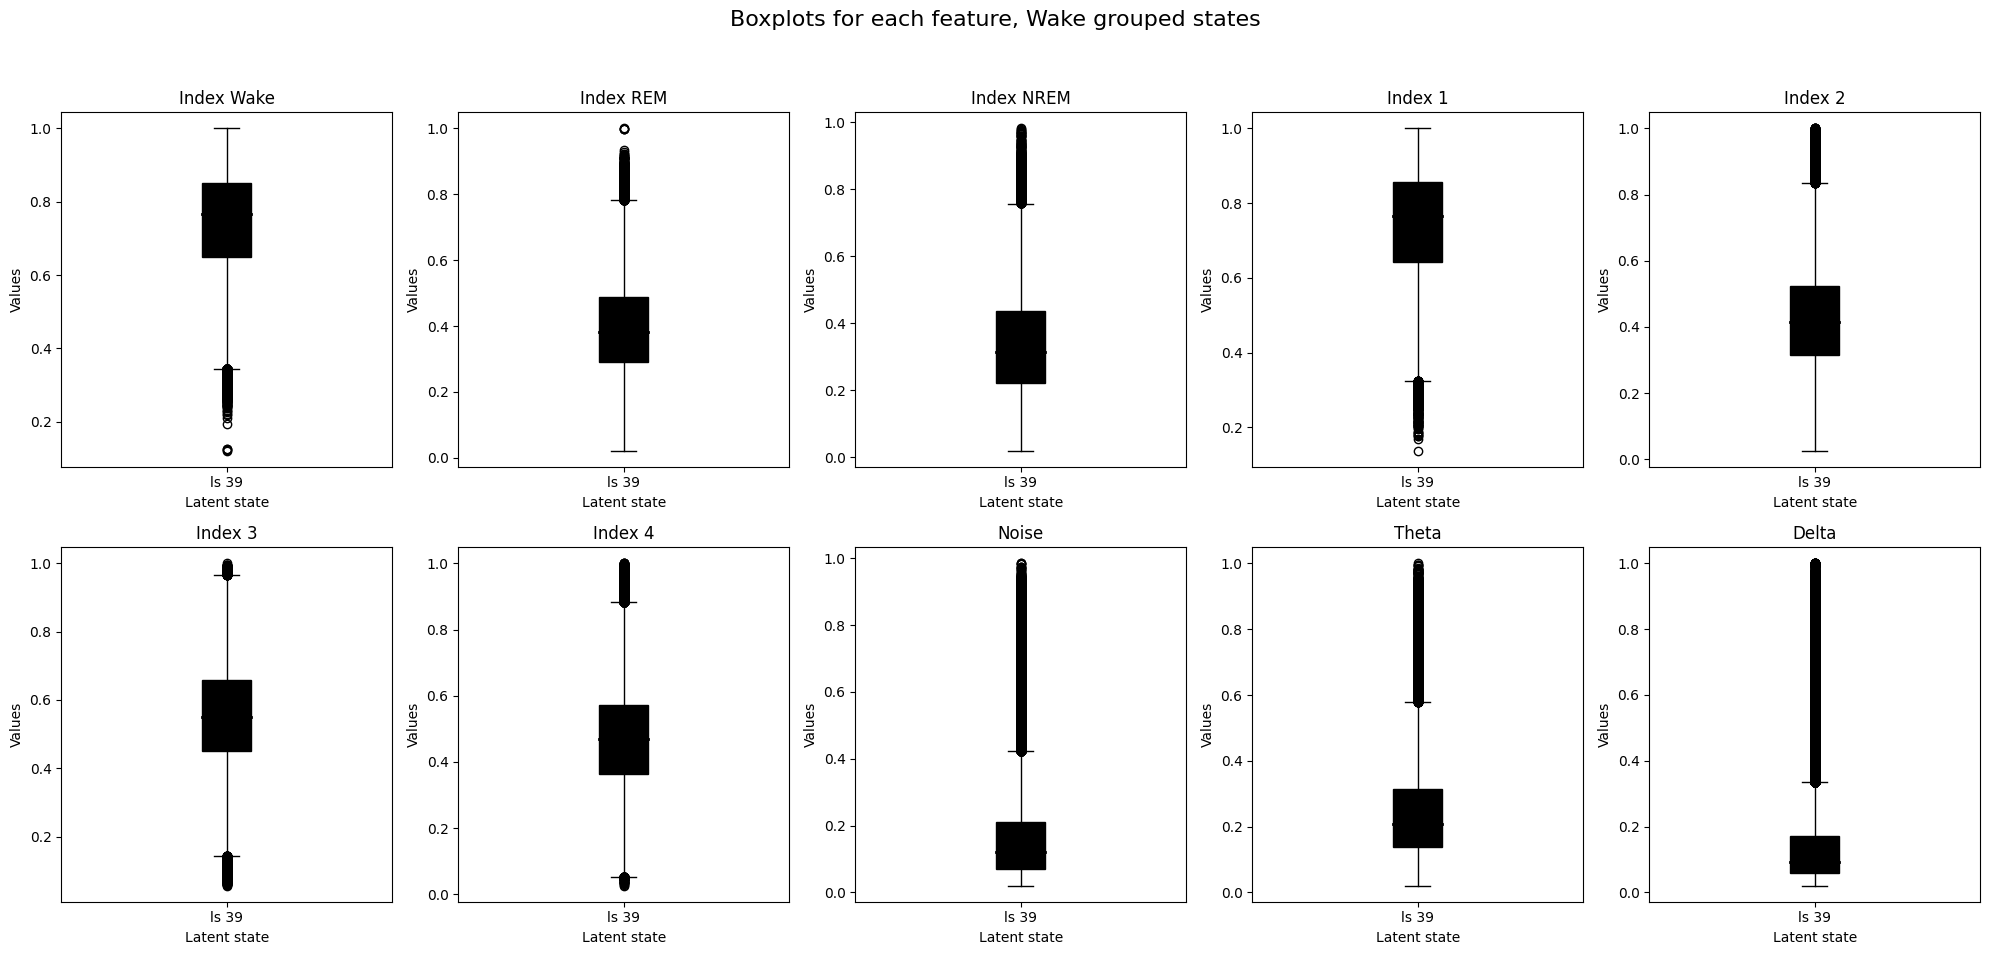

In [34]:
#@title Boxplots Wake latent groups

feats = ['Index Wake', 'Index REM', 'Index NREM', 'Index 1', 'Index 2', 'Index 3', 'Index 4', 'Noise', 'Theta', 'Delta']

# Dynamically generate colors based on the number of latent states
num_states = len(wake_latent_groups)
cmap = plt.get_cmap("Greys_r")  # Choose a color map, e.g., 'Blues'
colors = [cmap(i / num_states) for i in range(num_states)]  # Generate colors

# Create a figure with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Boxplots for each feature, Wake grouped states', fontsize=16, color='black')
fig.patch.set_facecolor('white')

# Loop through each feature to create boxplots
for i in range(10):
    # Extract the data for the i-th feature from all latent states
    data = [state[:, i] for state in wake_latent_groups]

    # Create boxplot
    bp = axs[i // 5, i % 5].boxplot(data,
                                    patch_artist=True,  # Enable color filling
                                    medianprops=dict(color='black', linewidth=2))

    # Color the boxes with the dynamically generated colors
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')

    # Set titles and labels
    axs[i // 5, i % 5].set_title(feats[i], color='black')
    axs[i // 5, i % 5].set_xlabel('Latent state', color='black')
    axs[i // 5, i % 5].set_ylabel('Values', color='black')

    # Set x-ticks dynamically based on the number of latent states
    axs[i // 5, i % 5].set_xticks(range(1, num_states + 1))
    axs[i // 5, i % 5].set_xticklabels([j for j in wake_latent_groups_names], color='black')

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('WakeGroupedLsBoxplots.svg', format = 'svg')
plt.show()

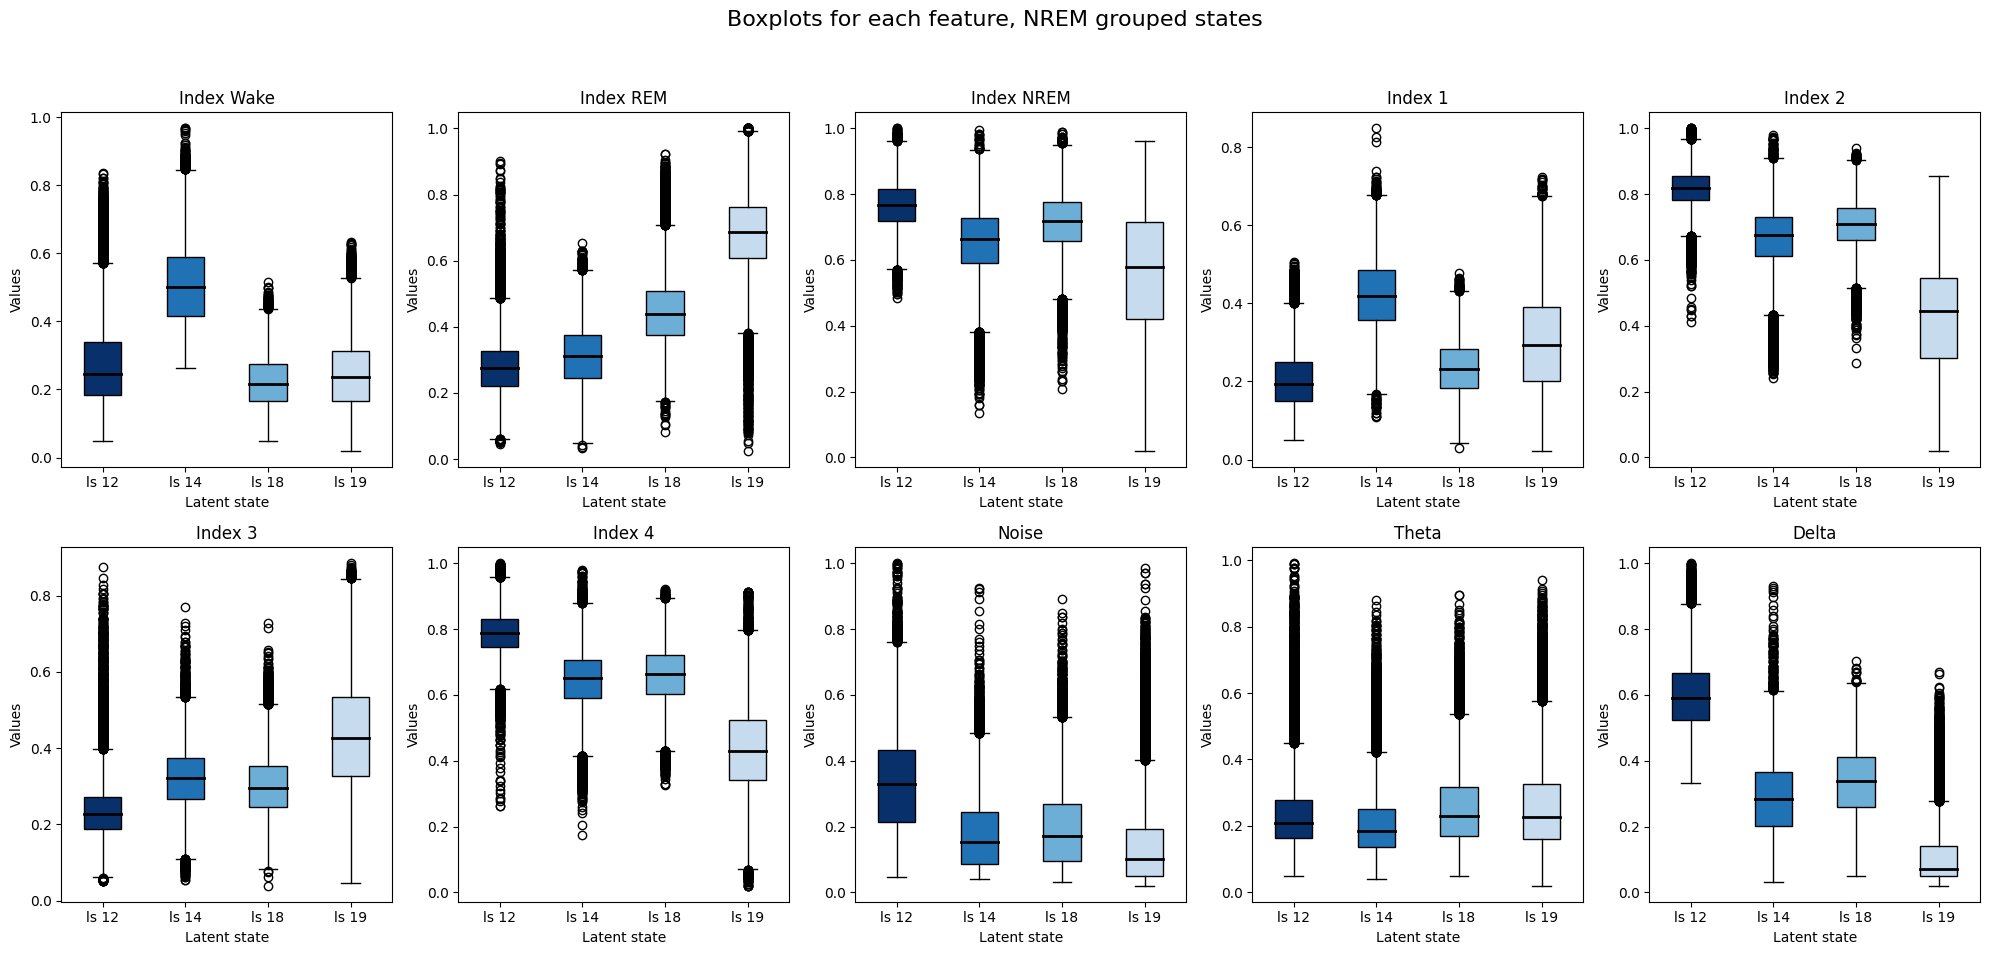

In [35]:
#@title Boxplots NREM latent groups

feats = ['Index Wake', 'Index REM', 'Index NREM', 'Index 1', 'Index 2', 'Index 3', 'Index 4', 'Noise', 'Theta', 'Delta']

# Dynamically generate colors based on the number of latent states
num_states = len(nrem_latent_groups)
cmap = plt.get_cmap("Blues_r")  # Choose a color map, e.g., 'Blues'
colors = [cmap(i / num_states) for i in range(num_states)]  # Generate colors

# Create a figure with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Boxplots for each feature, NREM grouped states', fontsize=16, color='black')
fig.patch.set_facecolor('white')

# Loop through each feature to create boxplots
for i in range(10):
    # Extract the data for the i-th feature from all latent states
    data = [state[:, i] for state in nrem_latent_groups]

    # Create boxplot
    bp = axs[i // 5, i % 5].boxplot(data,
                                    patch_artist=True,  # Enable color filling
                                    medianprops=dict(color='black', linewidth=2))

    # Color the boxes with the dynamically generated colors
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')

    # Set titles and labels
    axs[i // 5, i % 5].set_title(feats[i], color='black')
    axs[i // 5, i % 5].set_xlabel('Latent state', color='black')
    axs[i // 5, i % 5].set_ylabel('Values', color='black')

    # Set x-ticks dynamically based on the number of latent states
    axs[i // 5, i % 5].set_xticks(range(1, num_states + 1))
    axs[i // 5, i % 5].set_xticklabels([j for j in nrem_latent_groups_names], color='black')

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('NREMGroupedLsBoxplots.svg', format = 'svg')
plt.show()

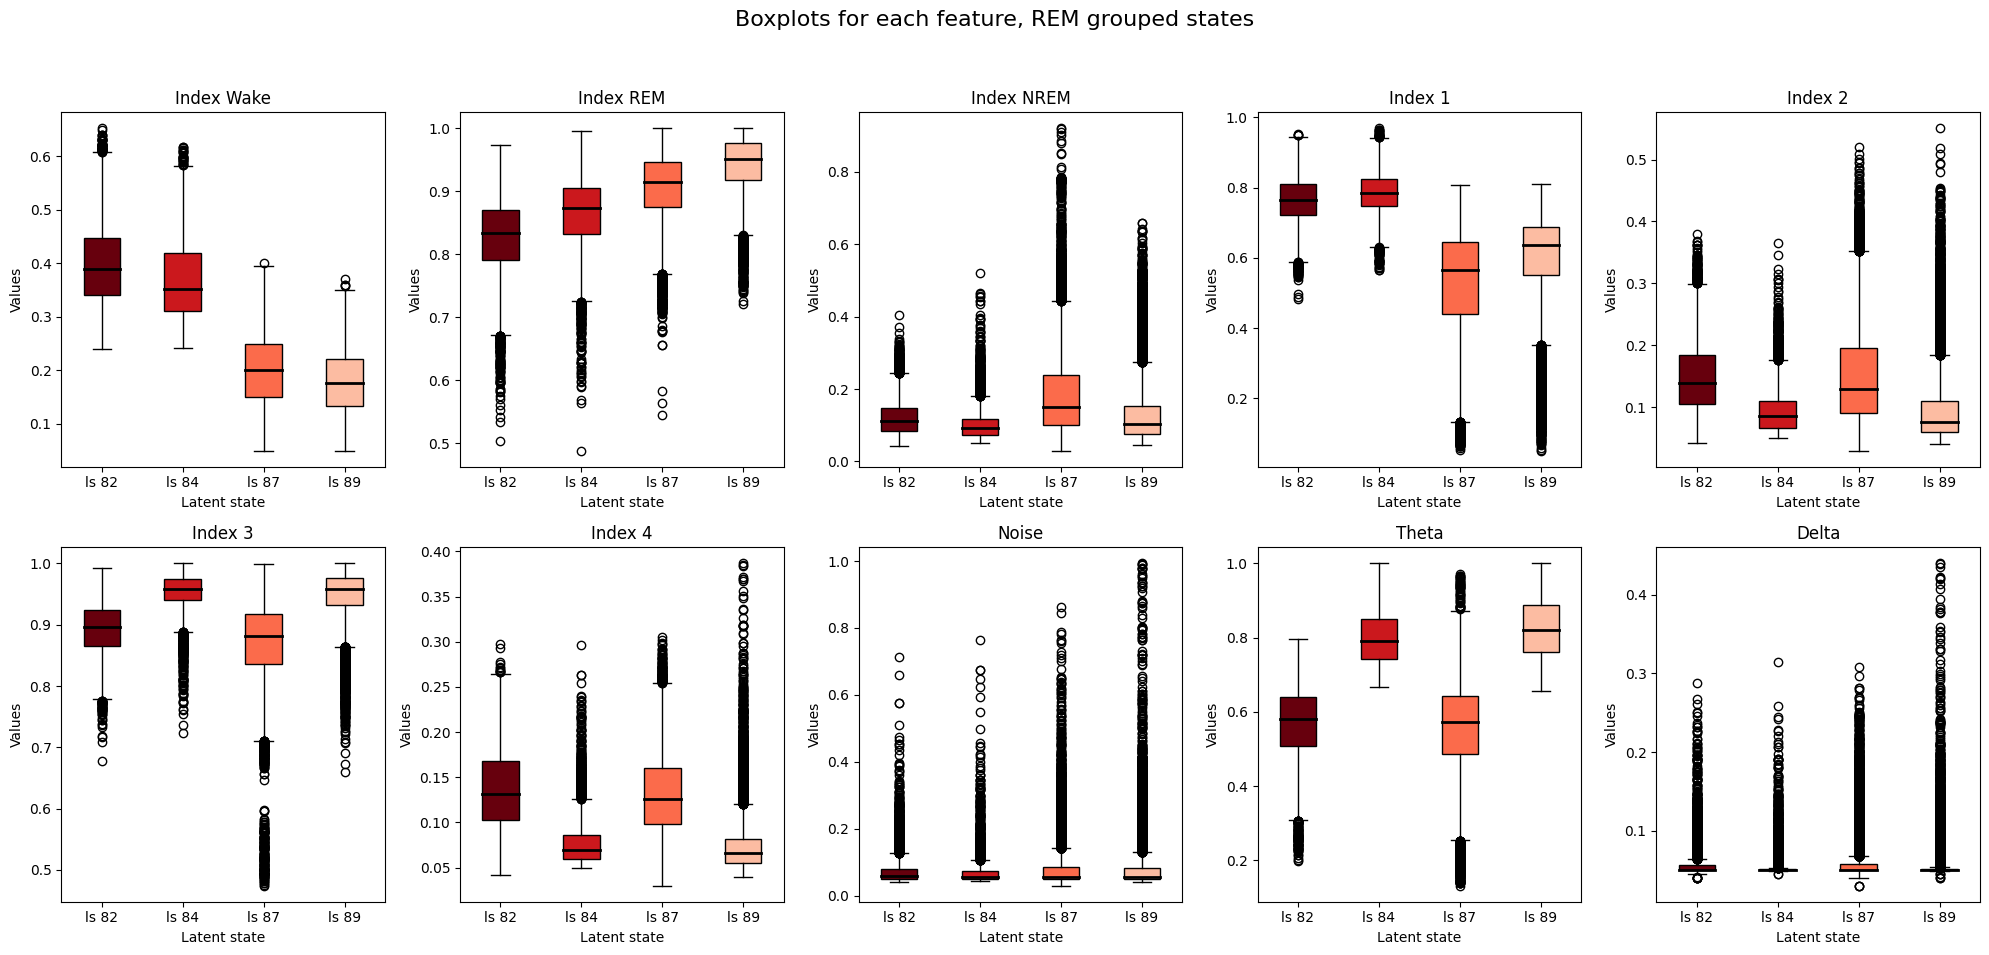

In [36]:
#@title Boxplots REM latent groups

feats = ['Index Wake', 'Index REM', 'Index NREM', 'Index 1', 'Index 2', 'Index 3', 'Index 4', 'Noise', 'Theta', 'Delta']

# Dynamically generate colors based on the number of latent states
num_states = len(rem_latent_groups)
cmap = plt.get_cmap("Reds_r")  # Choose a color map, e.g., 'Blues'
colors = [cmap(i / num_states) for i in range(num_states)]  # Generate colors

# Create a figure with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Boxplots for each feature, REM grouped states', fontsize=16, color='black')
fig.patch.set_facecolor('white')

# Loop through each feature to create boxplots
for i in range(10):
    # Extract the data for the i-th feature from all latent states
    data = [state[:, i] for state in rem_latent_groups]

    # Create boxplot
    bp = axs[i // 5, i % 5].boxplot(data,
                                    patch_artist=True,  # Enable color filling
                                    medianprops=dict(color='black', linewidth=2))

    # Color the boxes with the dynamically generated colors
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')

    # Set titles and labels
    axs[i // 5, i % 5].set_title(feats[i], color='black')
    axs[i // 5, i % 5].set_xlabel('Latent state', color='black')
    axs[i // 5, i % 5].set_ylabel('Values', color='black')

    # Set x-ticks dynamically based on the number of latent states
    axs[i // 5, i % 5].set_xticks(range(1, num_states + 1))
    axs[i // 5, i % 5].set_xticklabels([j for j in rem_latent_groups_names], color='black')

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('REMGroupedLsBoxplots.svg', format = 'svg')
plt.show()

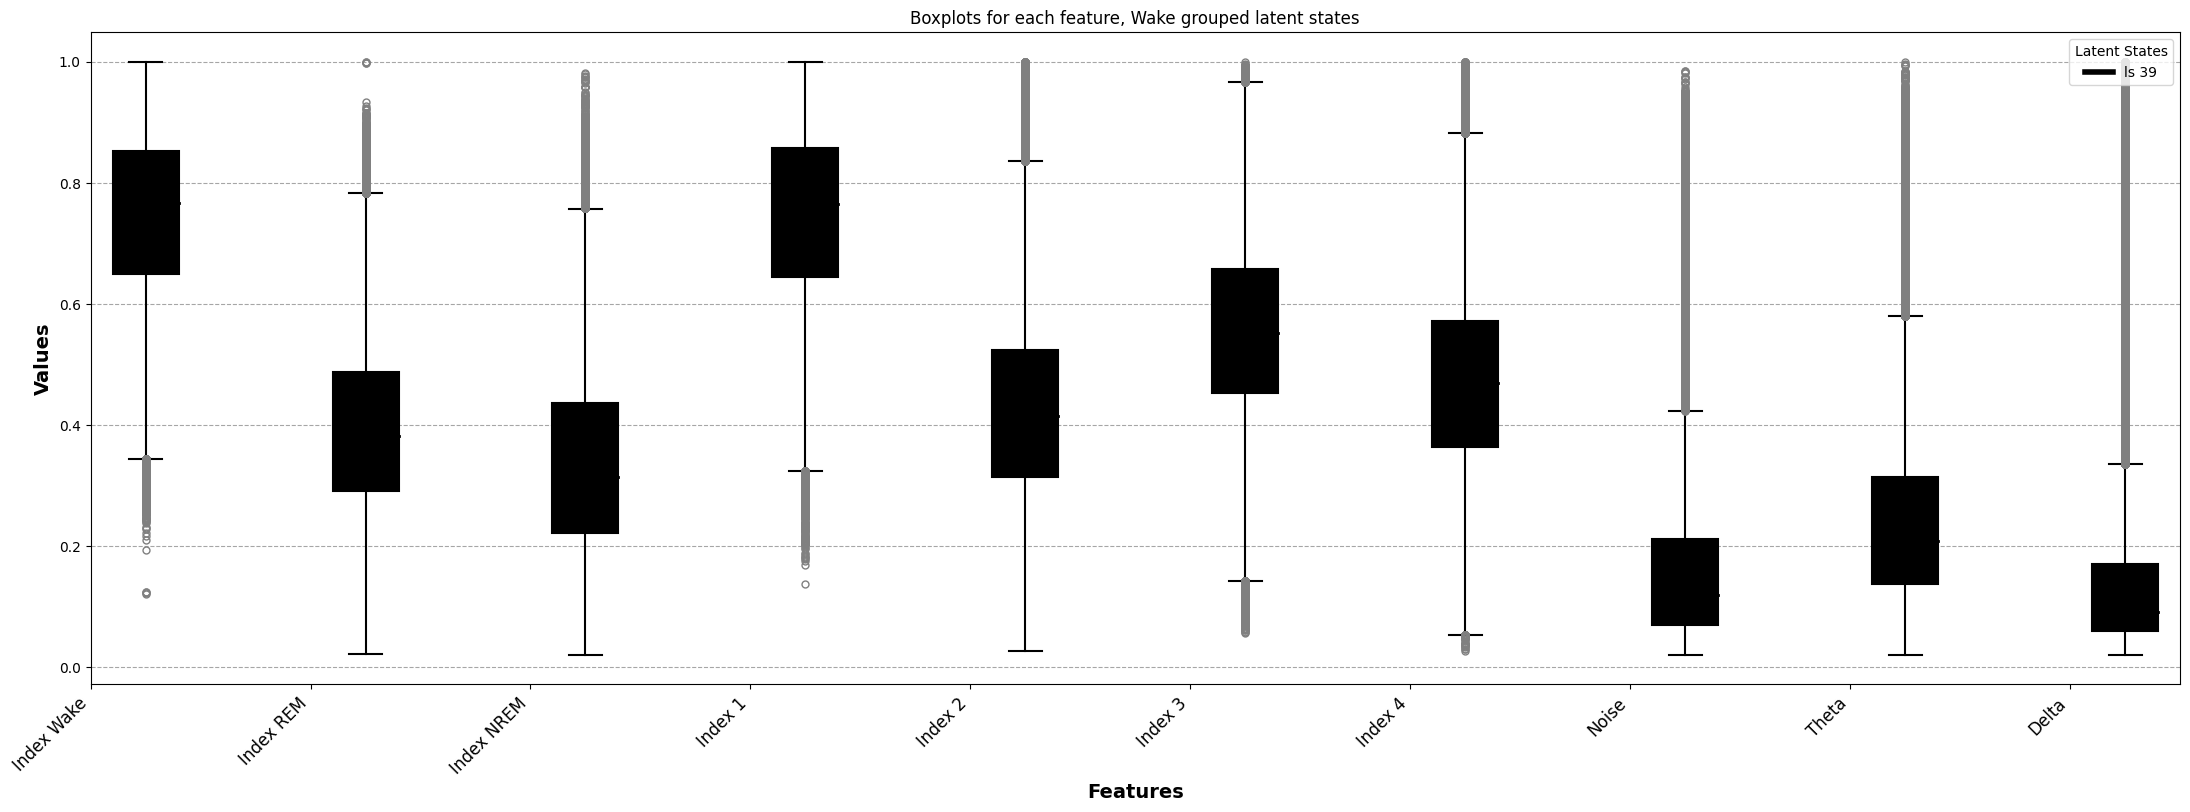

In [56]:
#@title Boxplots Wake latent groups all in one

feats = ['Index Wake', 'Index REM', 'Index NREM', 'Index 1', 'Index 2',
         'Index 3', 'Index 4', 'Noise', 'Theta', 'Delta']

# Dynamically generate colors based on the number of latent states
num_states = len(wake_latent_groups)
cmap = plt.get_cmap("Greys_r")  # Choose a color map
colors = [cmap(i / num_states) for i in range(num_states)]  # Generate colors

# Create a figure
fig, ax = plt.subplots(figsize=(22, 8))  # Adjust size as needed

# To keep track of positions for boxplots
positions = []
start_pos = 1
width = 0.6  # Width of each boxplot group

# Loop through each feature to create boxplots
for i, feat in enumerate(feats):
    # Extract the data for the i-th feature from all latent states
    data = [state[:, i] for state in wake_latent_groups]

    # Calculate positions for the current group of boxplots
    pos = [start_pos + j * width for j in range(num_states)]
    positions.extend(pos)

    # Create boxplots
    bp = ax.boxplot(data, positions=pos, widths=width,
                    patch_artist=True,  # Enable color filling
                    medianprops=dict(color='black', linewidth=2),
                    boxprops=dict(linewidth=1.5),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5),
                    flierprops=dict(marker='o', markersize=5, linestyle='none', markeredgecolor='gray'))

    # Color the boxes with the dynamically generated colors
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')

    # Increment the start position for the next group of boxplots
    start_pos += (num_states + 1)  # Add space between groups

# Set the x-ticks and labels
ax.set_xticks([(i * (num_states + 1)) + (num_states / 2) for i in range(len(feats))])
ax.set_xticklabels(feats, rotation=45, ha='right', fontsize=12)

# Set axis labels
ax.set_xlabel('Features', fontsize=14, weight='bold')
ax.set_ylabel('Values', fontsize=14, weight='bold')

# Enhance grid visibility
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)

# Create a legend with labels for each color corresponding to latent states
handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(num_states)]
ax.legend(handles, wake_latent_groups_names, title="Latent States", loc='upper right')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.title('Boxplots for each feature, Wake grouped latent states')
# Save the figure
plt.savefig('WakeGroupedLsBoxplots_AllInOne.svg', format='svg')

# Display the plot
plt.show()

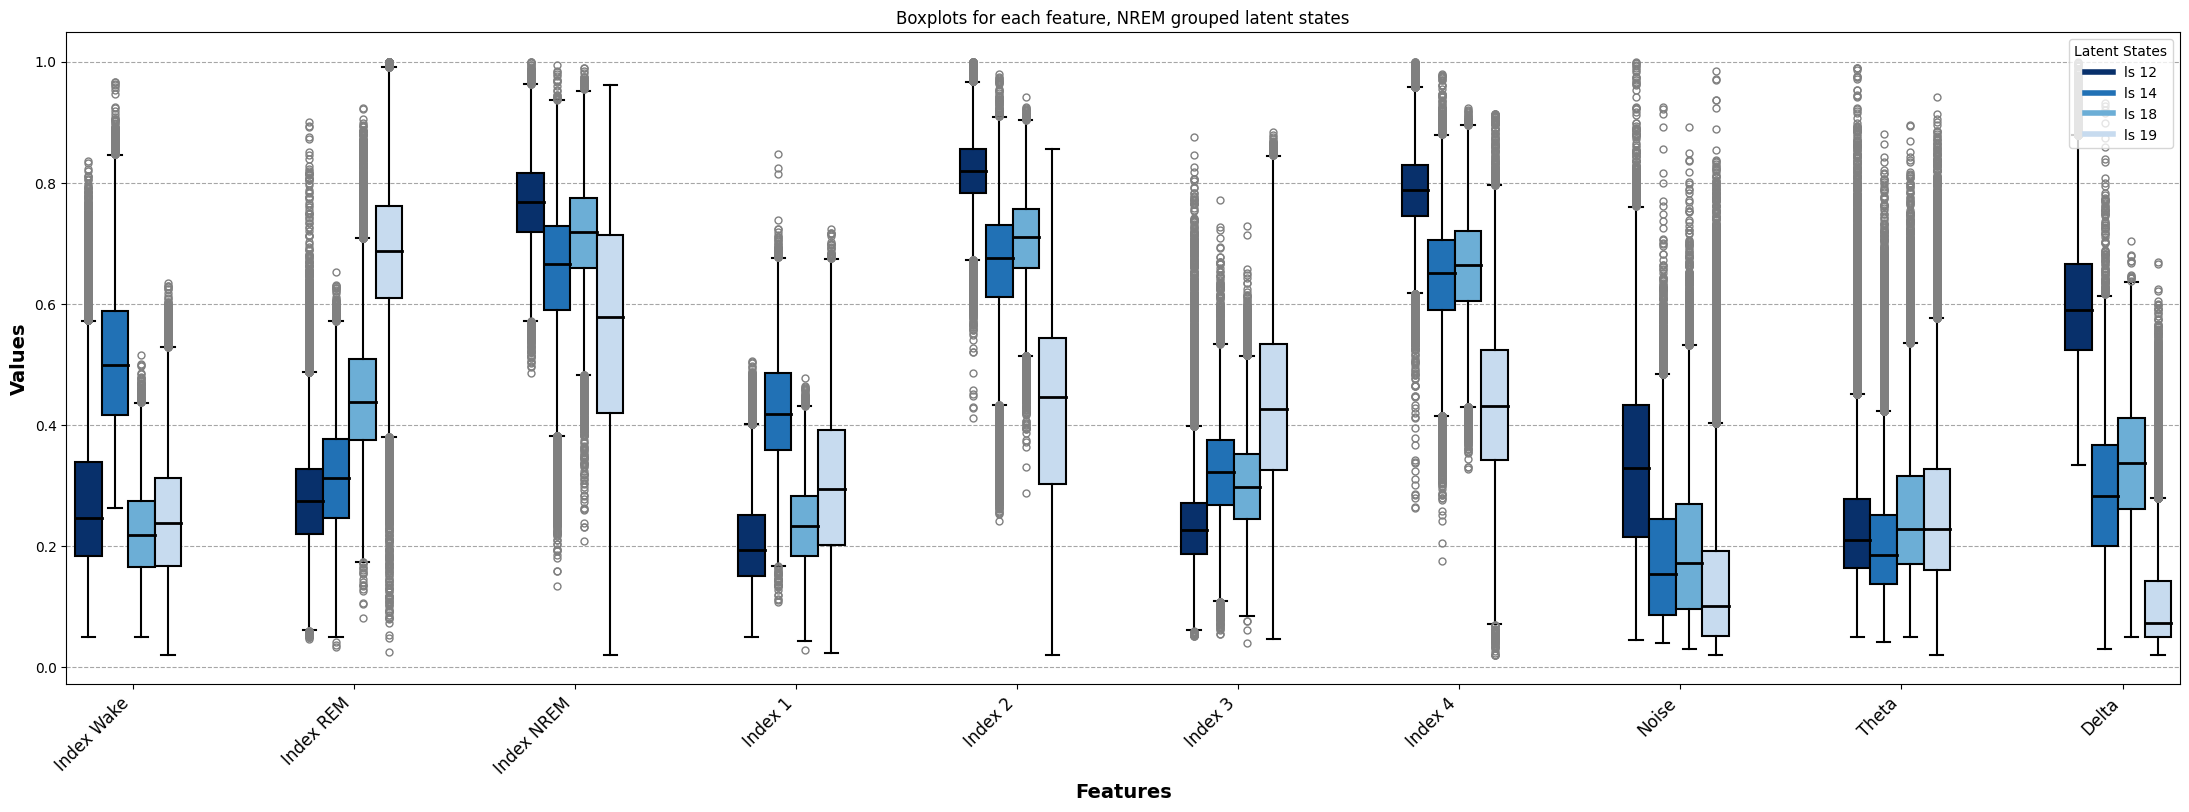

In [53]:
#@title Boxplots NREM latent groups all in one

feats = ['Index Wake', 'Index REM', 'Index NREM', 'Index 1', 'Index 2',
         'Index 3', 'Index 4', 'Noise', 'Theta', 'Delta']

# Dynamically generate colors based on the number of latent states
num_states = len(nrem_latent_groups)
cmap = plt.get_cmap("Blues_r")  # Choose a color map
colors = [cmap(i / num_states) for i in range(num_states)]  # Generate colors

# Create a figure
fig, ax = plt.subplots(figsize=(22, 8))  # Adjust size as needed

# To keep track of positions for boxplots
positions = []
start_pos = 1
width = 0.6  # Width of each boxplot group

# Loop through each feature to create boxplots
for i, feat in enumerate(feats):
    # Extract the data for the i-th feature from all latent states
    data = [state[:, i] for state in nrem_latent_groups]

    # Calculate positions for the current group of boxplots
    pos = [start_pos + j * width for j in range(num_states)]
    positions.extend(pos)

    # Create boxplots
    bp = ax.boxplot(data, positions=pos, widths=width,
                    patch_artist=True,  # Enable color filling
                    medianprops=dict(color='black', linewidth=2),
                    boxprops=dict(linewidth=1.5),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5),
                    flierprops=dict(marker='o', markersize=5, linestyle='none', markeredgecolor='gray'))

    # Color the boxes with the dynamically generated colors
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')

    # Increment the start position for the next group of boxplots
    start_pos += (num_states + 1)  # Add space between groups

# Set the x-ticks and labels
ax.set_xticks([(i * (num_states + 1)) + (num_states / 2) for i in range(len(feats))])
ax.set_xticklabels(feats, rotation=45, ha='right', fontsize=12)

# Set axis labels
ax.set_xlabel('Features', fontsize=14, weight='bold')
ax.set_ylabel('Values', fontsize=14, weight='bold')

# Enhance grid visibility
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)

# Create a legend with labels for each color corresponding to latent states
handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(num_states)]
ax.legend(handles, nrem_latent_groups_names, title="Latent States", loc='upper right')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.title('Boxplots for each feature, NREM grouped latent states')
# Save the figure
plt.savefig('NREMGroupedLsBoxplots_AllInOne.svg', format='svg')

# Display the plot
plt.show()

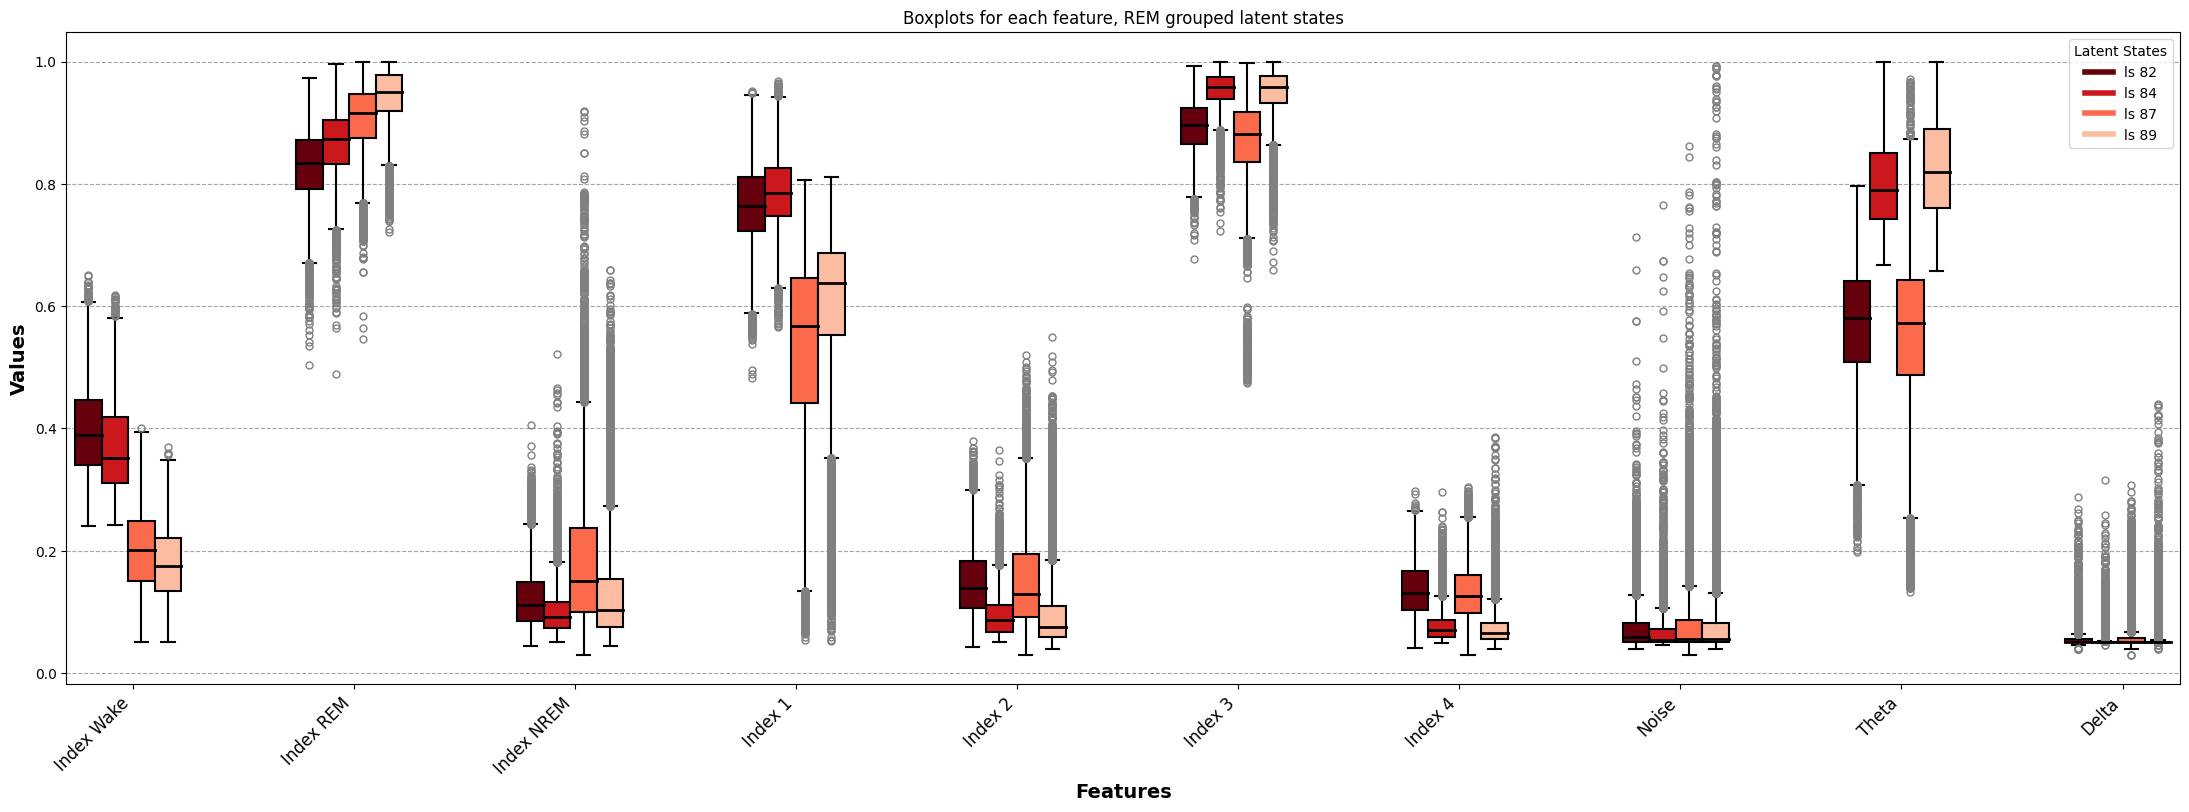

In [57]:
#@title Boxplots REM latent groups all in one

feats = ['Index Wake', 'Index REM', 'Index NREM', 'Index 1', 'Index 2',
         'Index 3', 'Index 4', 'Noise', 'Theta', 'Delta']

# Dynamically generate colors based on the number of latent states
num_states = len(rem_latent_groups)
cmap = plt.get_cmap("Reds_r")  # Choose a color map
colors = [cmap(i / num_states) for i in range(num_states)]  # Generate colors

# Create a figure
fig, ax = plt.subplots(figsize=(22, 8))  # Adjust size as needed

# To keep track of positions for boxplots
positions = []
start_pos = 1
width = 0.6  # Width of each boxplot group

# Loop through each feature to create boxplots
for i, feat in enumerate(feats):
    # Extract the data for the i-th feature from all latent states
    data = [state[:, i] for state in rem_latent_groups]

    # Calculate positions for the current group of boxplots
    pos = [start_pos + j * width for j in range(num_states)]
    positions.extend(pos)

    # Create boxplots
    bp = ax.boxplot(data, positions=pos, widths=width,
                    patch_artist=True,  # Enable color filling
                    medianprops=dict(color='black', linewidth=2),
                    boxprops=dict(linewidth=1.5),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5),
                    flierprops=dict(marker='o', markersize=5, linestyle='none', markeredgecolor='gray'))

    # Color the boxes with the dynamically generated colors
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')

    # Increment the start position for the next group of boxplots
    start_pos += (num_states + 1)  # Add space between groups

# Set the x-ticks and labels
ax.set_xticks([(i * (num_states + 1)) + (num_states / 2) for i in range(len(feats))])
ax.set_xticklabels(feats, rotation=45, ha='right', fontsize=12)

# Set axis labels
ax.set_xlabel('Features', fontsize=14, weight='bold')
ax.set_ylabel('Values', fontsize=14, weight='bold')

# Enhance grid visibility
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)

# Create a legend with labels for each color corresponding to latent states
handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(num_states)]
ax.legend(handles, rem_latent_groups_names, title="Latent States", loc='upper right')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.title('Boxplots for each feature, REM grouped latent states')
# Save the figure
plt.savefig('REMGroupedLsBoxplots_AllInOne.svg', format='svg')

# Display the plot
plt.show()

---
---
# Plot on LFP
Upload a post trial's data (obsKeys, latentStates, uniqueStates and RAW hpc and pfc)

### Load data
Plotting on lfp will allow for visualisation of these grouped latent states on the raw signals.

This requires the data from the run on a post trial + raw PFC and HPC signals.

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
path_to_pt5 = '/content/drive/My Drive/Donders/Automated Sleep Scoring/RGS_Rat3_SD14_HC_Pt5'

In [39]:
fs = 1000
window_length = fs*2
epoch_length = int(window_length/fs)

latent_states_pt = np.load('latentStatespt.npz')
unique_states_pt = np.load('uniqueStatespt.npz')
obs_keys_pt = np.load('obsKeyspt.npz')
inferredStates_pt = latent_states_pt['inferredStates']
inferred_states_pt = inferredStates_pt[:,0]
uniqueStates_pt = unique_states_pt['uniqueStates']
obsKeys_pt = obs_keys_pt['obsKeys']
uniqueStatesStr = [''.join(map(str, row[13:].astype(int))) for row in uniqueStates]
uniqueStatesStr_pt = [''.join(map(str, row[13:].astype(int))) for row in uniqueStates_pt]

In [40]:
# Load states from pt5 (artefact already marked at 0)
states = inferredStates_pt[:,1]
upsampled_states = np.repeat(states, 2*fs) # Upsample states to match other data

# Loading HPC raw data and truncate the end to get exact match
hpc_data = loadmat(path_to_pt5 + '/Rat3_SD14_HC_3_posttrial5_HPC')
hpc_data = hpc_data['HPC']
hpc_data = hpc_data[8*fs:]
raw_hpc = np.ravel(hpc_data)
raw_hpc = raw_hpc[0:len(upsampled_states)]

# Loading PFC raw data and truncate the end to get exact match
pfc_data = loadmat(path_to_pt5 + '/Rat3_SD14_HC_3_posttrial5_PFC')
pfc_data = pfc_data['PFC']
pfc_data = pfc_data[8*fs:]
raw_pfc = np.ravel(pfc_data)
raw_pfc = raw_pfc[0:len(upsampled_states)]

# Mark as NaN all elements that are either artefact or transitional states(TS) - so that these don't appear in the plots
indices = np.where((upsampled_states != 1) & (upsampled_states != 3) & (upsampled_states != 5))[0]  # Get indices of all epochs that are not in the inferred states epochs (score = 0 and 4)
raw_hpc[indices] = np.nan
raw_pfc[indices] = np.nan
upsampled_states[indices] = 0

### Assign the right latent state
Ensure that the running of the model didn't find any new latent states that wasn't present in the training. If it did, make sure it is small enough to be neglected.

inferred_states contains the latent states from the run on the posttrial (approx 50)
final_inferredStates_pt contains the latent states of the posttrial once they have been clustered accoriding to how it was done above for the training dataset.

In [41]:
#@title Any new latent states?
i = 0                                     # Check if any latent states were 'discovered' in the posttrial that weren't found in the training
for n in uniqueStatesStr_pt:
  if n not in uniqueStatesStr:
    i += 1
    print(n)
print('Number of new latent states:', i)

Number of new latent states: 0


In [42]:
def GetInferredStates(uniqueStates, obsKeys, uniqueStatesStr, obsKeys_pt, uniqueStates_pt, uniqueStatesStr_pt):
    majority_inferred_states = []

    # Iterate through each unique state in the training data
    for i in uniqueStates[:, 0]:
        # Find indices where the second column of obsKeys matches the current unique state
        idx = np.where(obsKeys[:, 1] == i)[0]

        # Extract frames corresponding to the current latent state
        latent_frames = obsKeys[idx, :]

        # Calculate the proportion of each state (awake, nrem, rem) in the latent frames
        awake_pct = round(len(np.where(latent_frames[:, 3] == 1)[0]) / float(len(latent_frames)), 3)
        nrem_pct = round(len(np.where(latent_frames[:, 3] == 3)[0]) / float(len(latent_frames)), 3)
        rem_pct = round(len(np.where(latent_frames[:, 3] == 5)[0]) / float(len(latent_frames)), 3)

        # Determine the majority state based on the proportions and append to the list
        if awake_pct >= nrem_pct and awake_pct >= rem_pct:
            majority_inferred_states.append(1)
        elif nrem_pct >= rem_pct and nrem_pct >= awake_pct:
            majority_inferred_states.append(3)
        elif rem_pct >= nrem_pct and rem_pct >= awake_pct:
            majority_inferred_states.append(5)

    # Initialize an array to store the inferred states for the test dataset
    inferred_states = np.zeros(len(obsKeys_pt[:, 1]))

    # Iterate through each unique state in the test data
    for i in range(len(uniqueStates_pt[:, 0])):
        # Find indices where the second column of obsKeys_pt matches the current unique state
        idx_pt = np.where(obsKeys_pt[:, 1] == uniqueStates_pt[i, 0])[0]

        # If the unique state string is not found in the training data, set inferred state to -1
        if uniqueStatesStr_pt[i] not in uniqueStatesStr:
            inferred_states[idx_pt] = -1
        else:
            # Otherwise, find the corresponding majority inferred state from training data
            for k in range(len(uniqueStatesStr)):
                if uniqueStatesStr[k] == uniqueStatesStr_pt[i]:
                    inferred_states[idx_pt] = k

    return inferred_states

inferred_states = GetInferredStates(uniqueStates, obsKeys, uniqueStatesStr, obsKeys_pt, uniqueStates_pt, uniqueStatesStr_pt)

In [43]:
inferred_states2 = np.copy(inferred_states)
for i in REM_mapping:
  inferred_states2[np.where(inferred_states == i+1)[0]] = REM_mapping[i]+1
for i in NREM_mapping:
  inferred_states2[np.where(inferred_states == i+1)[0]] = NREM_mapping[i]+1
for i in Wake_mapping:
  inferred_states2[np.where(inferred_states == i+1)[0]] = Wake_mapping[i]+1
for i in range(len(inferred_states2)):
  inferred_states2[i] = inferred_states2[i]-1
final_inferredStates_pt = np.copy(inferredStates_pt)
for i in range(len(inferred_states2)):
  final_inferredStates_pt[i] = [inferred_states2[i], final_inferredStates_pt[i,1]]       # This array contains the inferred states grouped like they were in the training (so went from ~50 latent states to ~10/15)

### Plot

#### Preparation

In [44]:
upsampled_latent_states = np.repeat(final_inferredStates_pt, 2*fs, axis = 0)

# Wake
Wake_indices_per_LSgroup = [np.where(upsampled_latent_states[:, 0] == state)[0] for state in wake_latent_groups_numbers]

# NREM
NREM_indices_per_LSgroup = [np.where(upsampled_latent_states[:, 0] == state)[0] for state in nrem_latent_groups_numbers]

# REM
REM_indices_per_LSgroup = [np.where(upsampled_latent_states[:, 0] == state)[0] for state in rem_latent_groups_numbers]

print('Wake groups sizes')
i=0
for state in wake_latent_groups_numbers:
    num_epochs = len(Wake_indices_per_LSgroup[i]) / (2 * fs)
    print(f'Epochs in latent {wake_latent_groups_numbers[i]} : {num_epochs}')
    i+=1

print('')
print('NREM groups sizes')
i=0
for state in nrem_latent_groups_numbers:
    num_epochs = len(NREM_indices_per_LSgroup[i]) / (2 * fs)
    print(f'Epochs in latent {nrem_latent_groups_numbers[i]} : {num_epochs}')
    i+=1

print('')
print('REM groups sizes')
i = 0
for state in rem_latent_groups_numbers:
    num_epochs = len(REM_indices_per_LSgroup[i]) / (2 * fs)
    print(f'Epochs in latent {rem_latent_groups_numbers[i]} : {num_epochs}')
    i+=1


Wake groups sizes
Epochs in latent 39 : 3906.0

NREM groups sizes
Epochs in latent 12 : 177.0
Epochs in latent 14 : 307.0
Epochs in latent 18 : 604.0
Epochs in latent 19 : 128.0

REM groups sizes
Epochs in latent 82 : 0.0
Epochs in latent 84 : 1.0
Epochs in latent 87 : 25.0
Epochs in latent 89 : 248.0


In [45]:
# Preparing arrays to plot
downsampling_factor = 50

# Wake
wake_hpc = [np.copy(raw_hpc) for i in wake_latent_groups_numbers]      # creating a copy of each signal for each group of latent states
wake_pfc = [np.copy(raw_pfc) for i in wake_latent_groups_numbers]
wake_mask = [np.ones_like(wake_hpc[i], dtype=bool) for i in range(len(wake_latent_groups_numbers))]
i = 0
for group_indices in Wake_indices_per_LSgroup:
  wake_mask[i][group_indices] = False                                  # creating mask with 0 at every indices in the current group of latent state. 1 otherwise.
  i+=1
i = 0
for mask in wake_mask:
  wake_hpc[i][wake_mask[i]] = np.nan                                   # setting to NaN all indices not in the target latent state group
  wake_pfc[i][wake_mask[i]] = np.nan
  i+=1
for i in range(len(wake_hpc)):                                         # Downsampling (So that we can plot intervals of len ~ 400 secs)
  wake_hpc[i] = wake_hpc[i][::downsampling_factor]
  wake_pfc[i] = wake_pfc[i][::downsampling_factor]


# NREM
nrem_hpc = [np.copy(raw_hpc) for i in nrem_latent_groups_numbers]
nrem_pfc = [np.copy(raw_pfc) for i in nrem_latent_groups_numbers]
nrem_mask = [np.ones_like(nrem_hpc[i], dtype=bool) for i in range(len(nrem_latent_groups_numbers))]
i=0
for group_indices in NREM_indices_per_LSgroup:
  nrem_mask[i][group_indices] = False
  i+=1
i = 0
for mask in nrem_mask:
  nrem_hpc[i][nrem_mask[i]] = np.nan
  nrem_pfc[i][nrem_mask[i]] = np.nan
  i+=1
for i in range(len(nrem_hpc)):
  nrem_hpc[i] = nrem_hpc[i][::downsampling_factor]
  nrem_pfc[i] = nrem_pfc[i][::downsampling_factor]


# REM
rem_hpc = [np.copy(raw_hpc) for i in rem_latent_groups_numbers]
rem_pfc = [np.copy(raw_pfc) for i in rem_latent_groups_numbers]
rem_mask = [np.ones_like(rem_hpc[i], dtype=bool) for i in range(len(nrem_latent_groups_numbers))]
i=0
for group_indices in REM_indices_per_LSgroup:
  rem_mask[i][group_indices] = False
  i+=1
i = 0
for mask in rem_mask:
  rem_hpc[i][rem_mask[i]] = np.nan
  rem_pfc[i][rem_mask[i]] = np.nan
  i+=1
for i in range(len(rem_hpc)):
  rem_hpc[i] = rem_hpc[i][::downsampling_factor]
  rem_pfc[i] = rem_pfc[i][::downsampling_factor]



# Downsampling (So that we can plot intervals of len ~ 400 secs)
raw_hpc = raw_hpc[::downsampling_factor]
raw_pfc = raw_pfc[::downsampling_factor]

upsampled_latent_states = upsampled_latent_states[::downsampling_factor]

new_fs = int(fs/downsampling_factor) # Let's not forget to set a new downsampled sampling frequency

#### Plots

<ipython-input-46-63da74ba76e4>:56: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


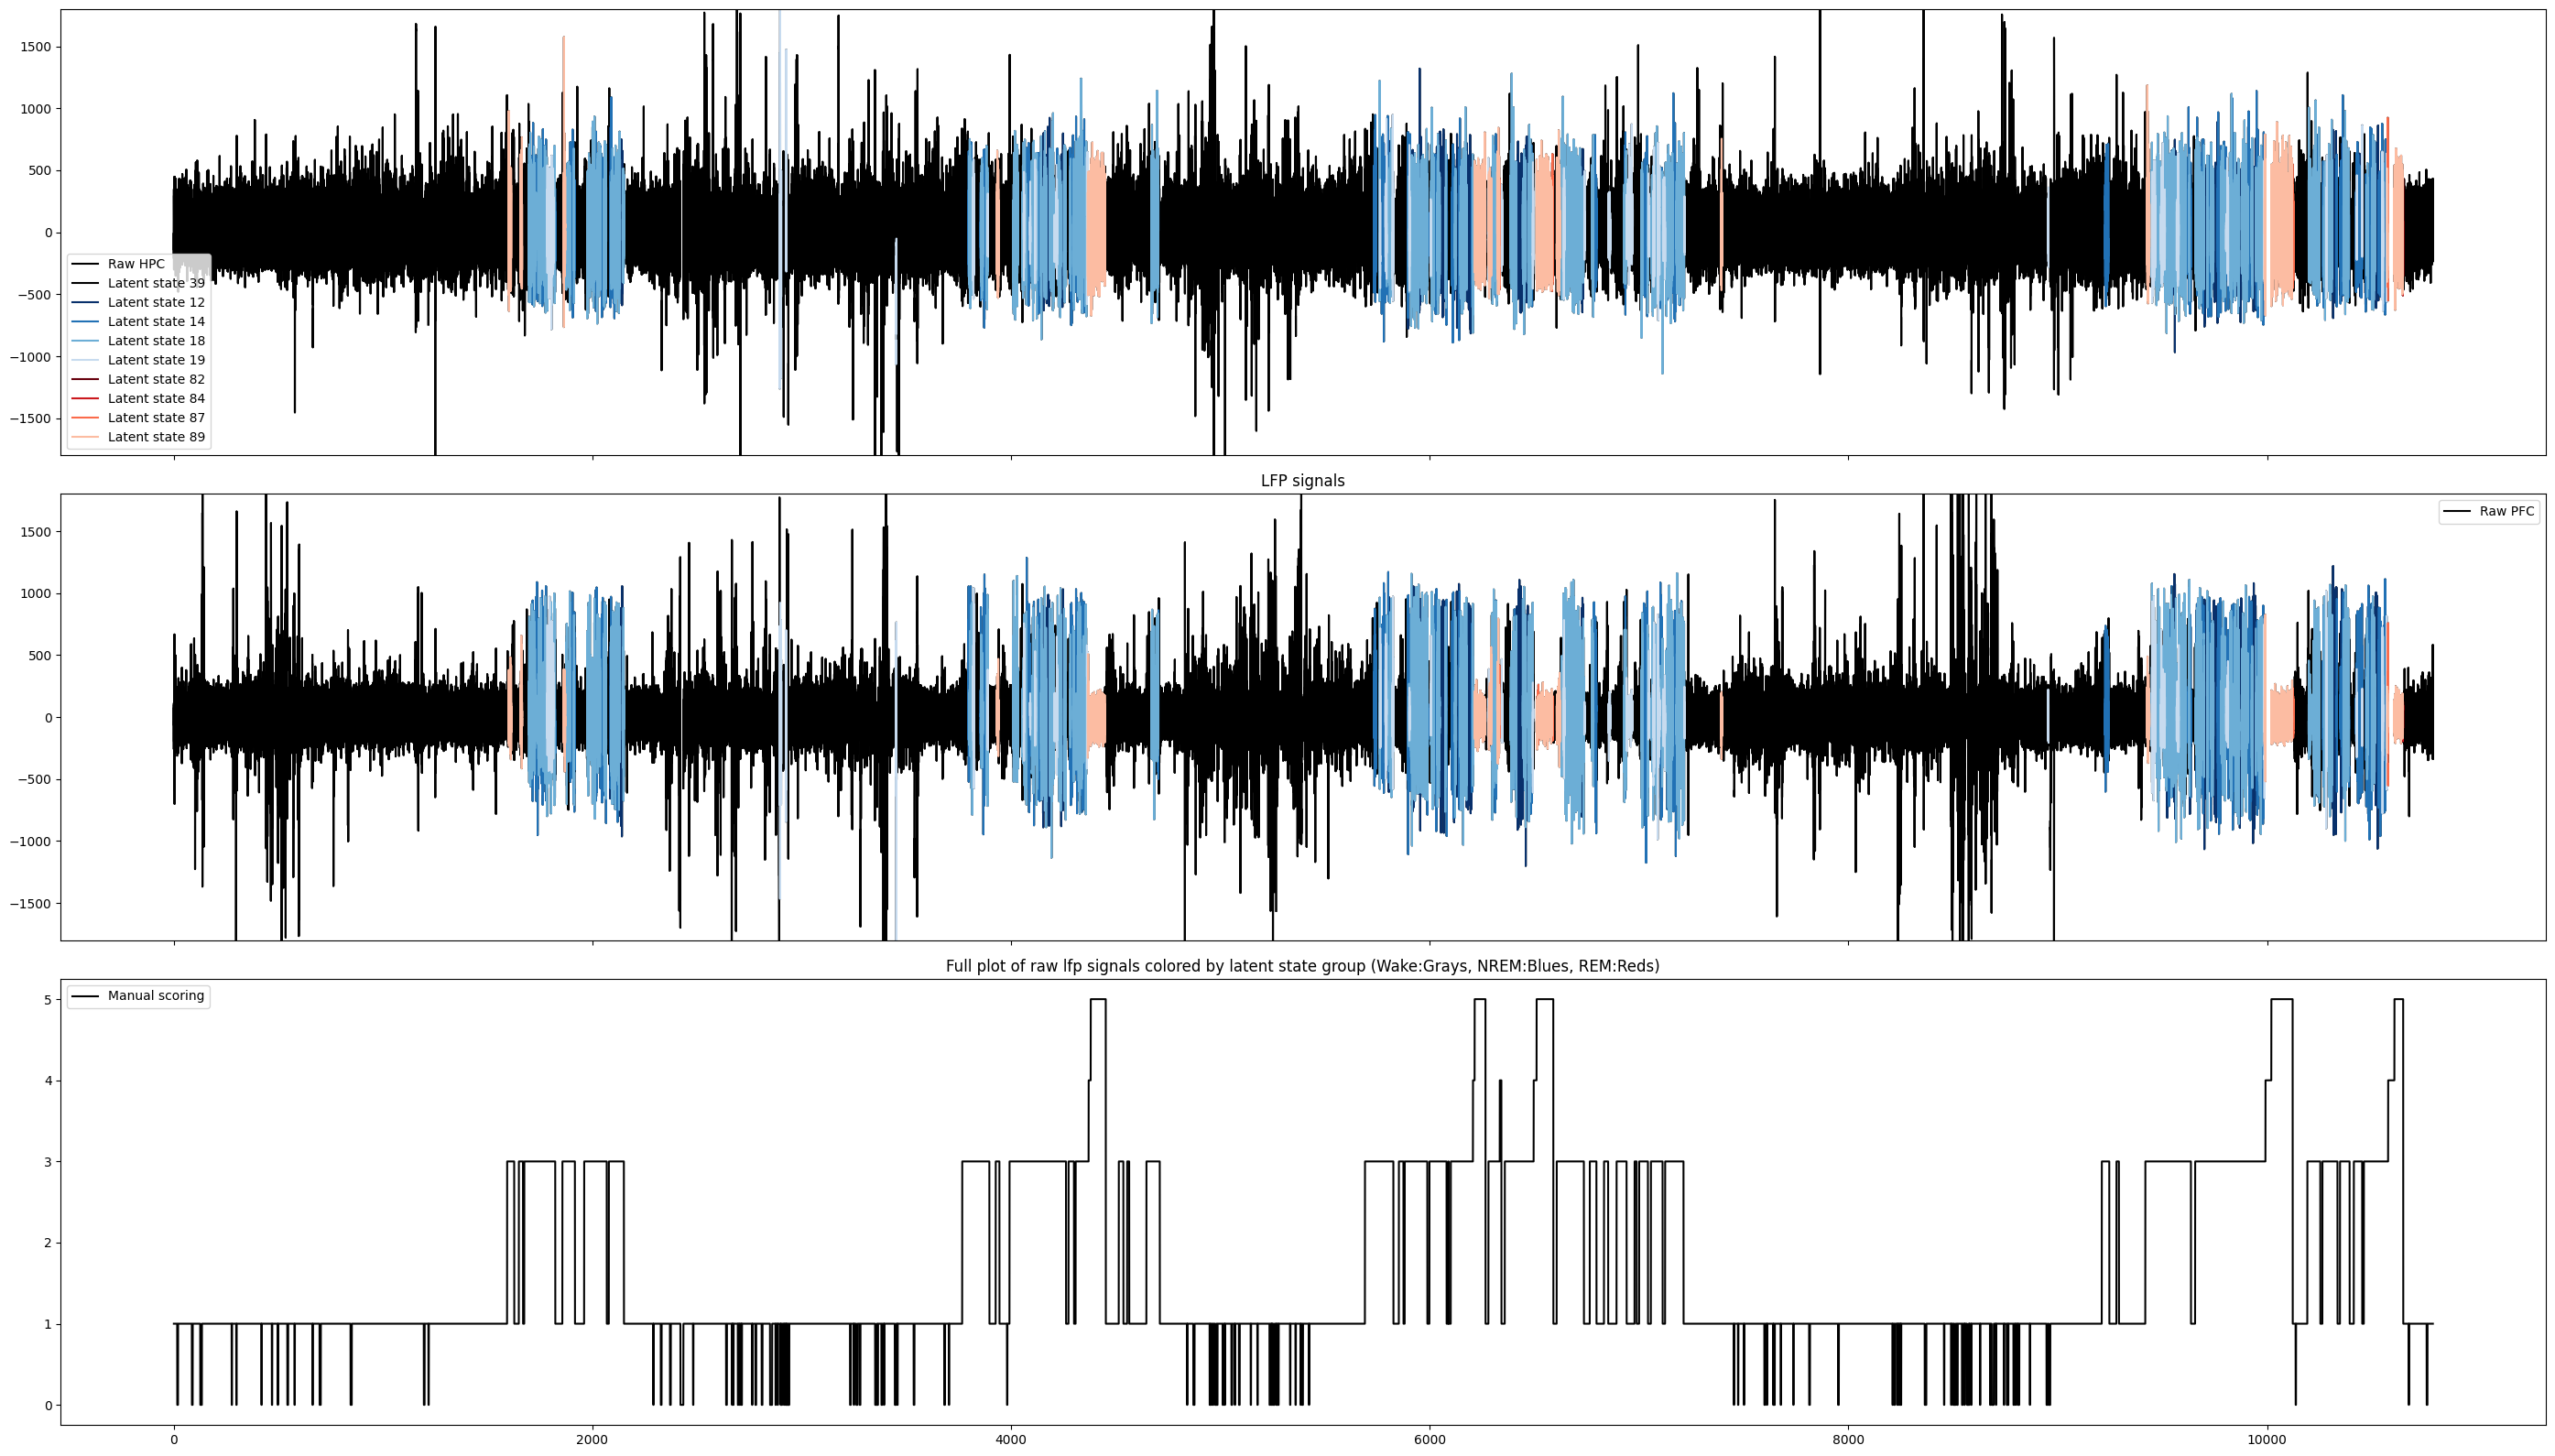

In [46]:
#@title Full post trial plot

x = np.arange(len(raw_hpc))/new_fs
times = np.arange(0, len(x))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (28, 16))                                           # Plot whole LFP signals and manual scores to get an overall view of target areas - cf zoom on these areas below

# Plot data on each subplot

# Base signal
ax1.plot(x[times], raw_hpc[times], label='Raw HPC', color = 'black')
ax2.plot(x[times], raw_pfc[times], label='Raw PFC', color = 'black')

# Wake highlights
cmap = plt.get_cmap("Greys_r")
colors = [cmap(i / len(wake_latent_groups_numbers)) for i in range(len(wake_latent_groups_numbers))]
i = 0
for i, data in enumerate(wake_hpc):
    ax1.plot(x[times], data[times], label=f'Latent state {wake_latent_groups_numbers[i]}', color=colors[i])
for i, data in enumerate(wake_pfc):
    ax2.plot(x[times], data[times], color=colors[i])

# NREM highlights
cmap = plt.get_cmap("Blues_r")
colors = [cmap(i / len(nrem_latent_groups_numbers)) for i in range(len(nrem_latent_groups_numbers))]
i = 0
for i, data in enumerate(nrem_hpc):
    ax1.plot(x[times], data[times], label=f'Latent state {nrem_latent_groups_numbers[i]}', color=colors[i])
for i, data in enumerate(nrem_pfc):
    ax2.plot(x[times], data[times], color=colors[i])

# REM highlights
cmap = plt.get_cmap("Reds_r")
colors = [cmap(i / len(rem_latent_groups_numbers)) for i in range(len(rem_latent_groups_numbers))]
i = 0
for i, data in enumerate(rem_hpc):
    ax1.plot(x[times], data[times], label=f'Latent state {rem_latent_groups_numbers[i]}', color=colors[i])
for i, data in enumerate(rem_pfc):
    ax2.plot(x[times], data[times], color=colors[i])


ax3.plot(x[times], upsampled_latent_states[:,1][times], label='Manual scoring', color = 'black')


ax2.set_title('LFP signals')
ax3.set_title('Manual scores')
# Add legends
ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_ylim([-1800, 1800])  # Adjust the range as needed for HPC
ax2.set_ylim([-1800, 1800])

# Adjust layout to avoid overlap
plt.title('Full plot of raw lfp signals colored by latent state group (Wake:Grays, NREM:Blues, REM:Reds)')
plt.tight_layout()
#plt.savefig('FullLFPs', format='pdf')

# Show the plots
plt.show()

# Blank spaces are either artefacts or manually scored as TS (transition state) (both scored as 0 here)

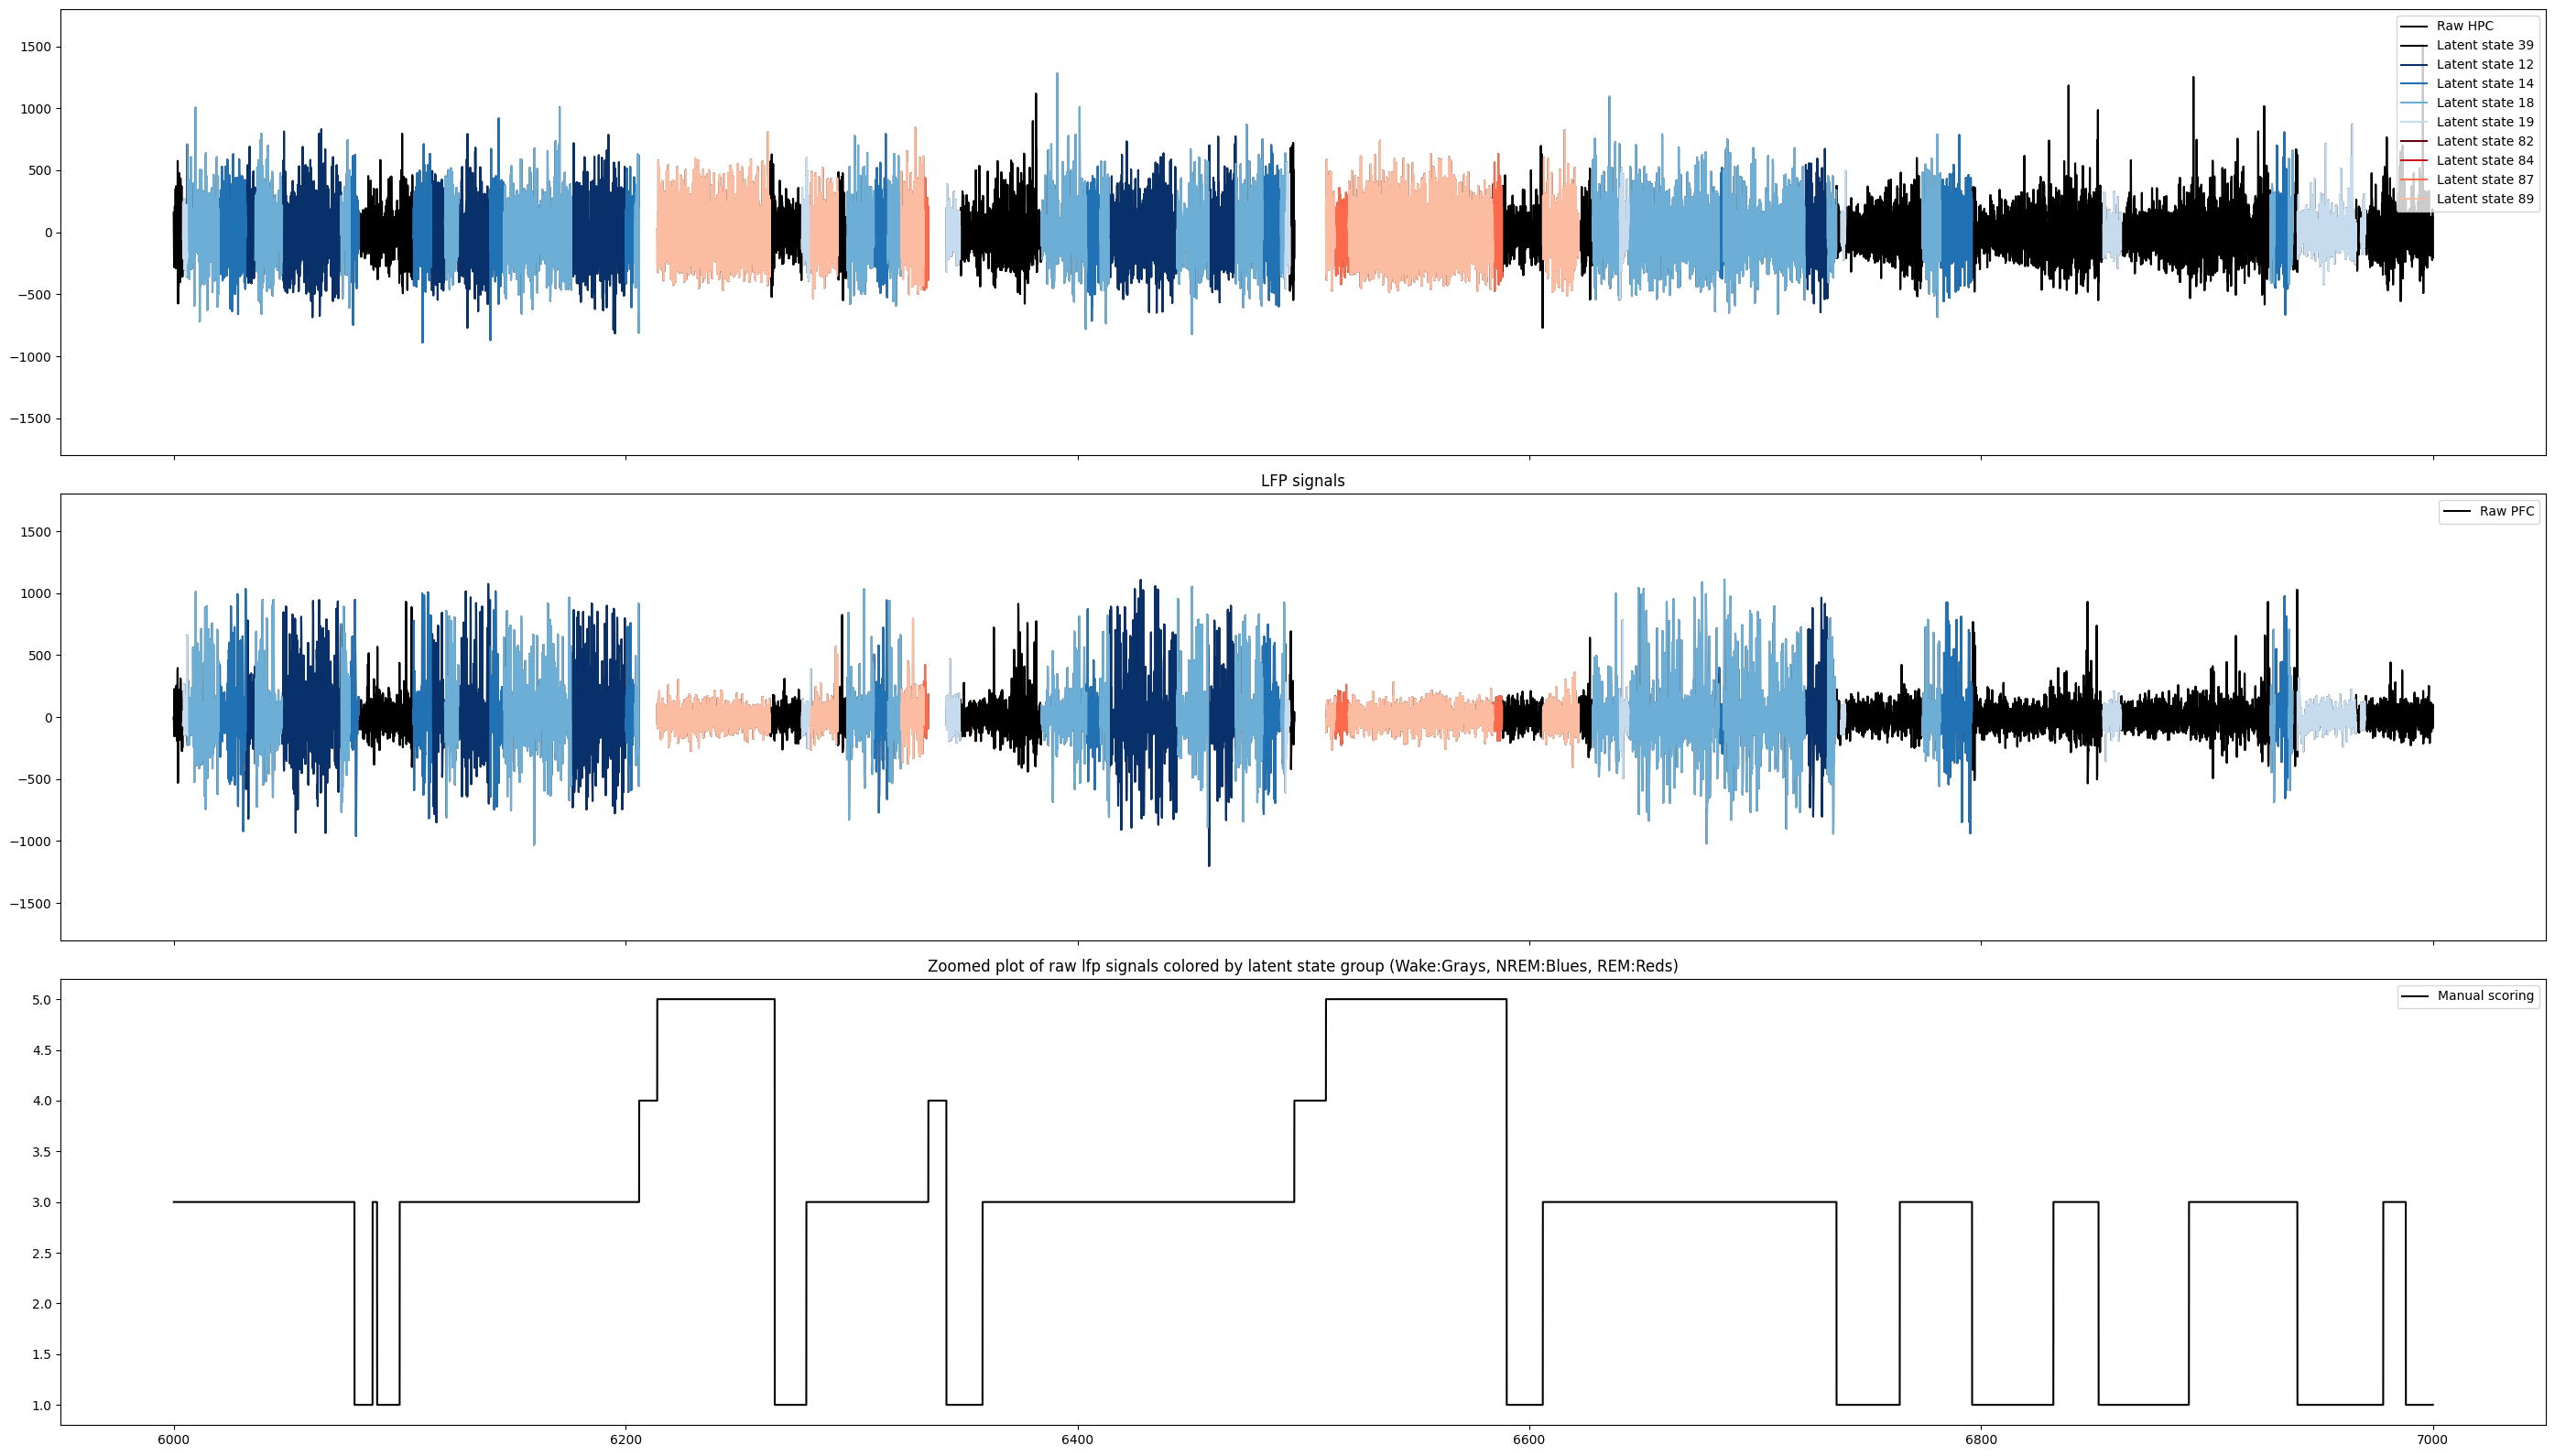

In [47]:
#@title Zoomed posttrial plot 1

x = np.arange(len(raw_hpc))/new_fs
times = np.arange(6000*new_fs, 7000*new_fs)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (28, 16))                                           # Plot whole LFP signals and manual scores to get an overall view of target areas - cf zoom on these areas below

# Plot data on each subplot

# Base signal
ax1.plot(x[times], raw_hpc[times], label='Raw HPC', color = 'black')
ax2.plot(x[times], raw_pfc[times], label='Raw PFC', color = 'black')

# Wake highlights
cmap = plt.get_cmap("Greys_r")
colors = [cmap(i / len(wake_latent_groups_numbers)) for i in range(len(wake_latent_groups_numbers))]
i = 0
for i, data in enumerate(wake_hpc):
    ax1.plot(x[times], data[times], label=f'Latent state {wake_latent_groups_numbers[i]}', color=colors[i])
for i, data in enumerate(wake_pfc):
    ax2.plot(x[times], data[times], color=colors[i])

# NREM highlights
cmap = plt.get_cmap("Blues_r")
colors = [cmap(i / len(nrem_latent_groups_numbers)) for i in range(len(nrem_latent_groups_numbers))]
i = 0
for i, data in enumerate(nrem_hpc):
    ax1.plot(x[times], data[times], label=f'Latent state {nrem_latent_groups_numbers[i]}', color=colors[i])
for i, data in enumerate(nrem_pfc):
    ax2.plot(x[times], data[times], color=colors[i])

# REM highlights
cmap = plt.get_cmap("Reds_r")
colors = [cmap(i / len(rem_latent_groups_numbers)) for i in range(len(rem_latent_groups_numbers))]
i = 0
for i, data in enumerate(rem_hpc):
    ax1.plot(x[times], data[times], label=f'Latent state {rem_latent_groups_numbers[i]}', color=colors[i])
for i, data in enumerate(rem_pfc):
    ax2.plot(x[times], data[times], color=colors[i])


ax3.plot(x[times], upsampled_latent_states[:,1][times], label='Manual scoring', color = 'black')


ax2.set_title('LFP signals')
ax3.set_title('Manual scores')
# Add legends
ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_ylim([-1800, 1800])  # Adjust the range as needed for HPC
ax2.set_ylim([-1800, 1800])

# Adjust layout to avoid overlap
plt.title('Zoomed plot of raw lfp signals colored by latent state group (Wake:Grays, NREM:Blues, REM:Reds)')
plt.tight_layout()
#plt.savefig('FullLFPs', format='pdf')

# Show the plots
plt.show()

# Blank spaces are either artefacts or manually scored as TS (transition state) (both scored as 0 here)

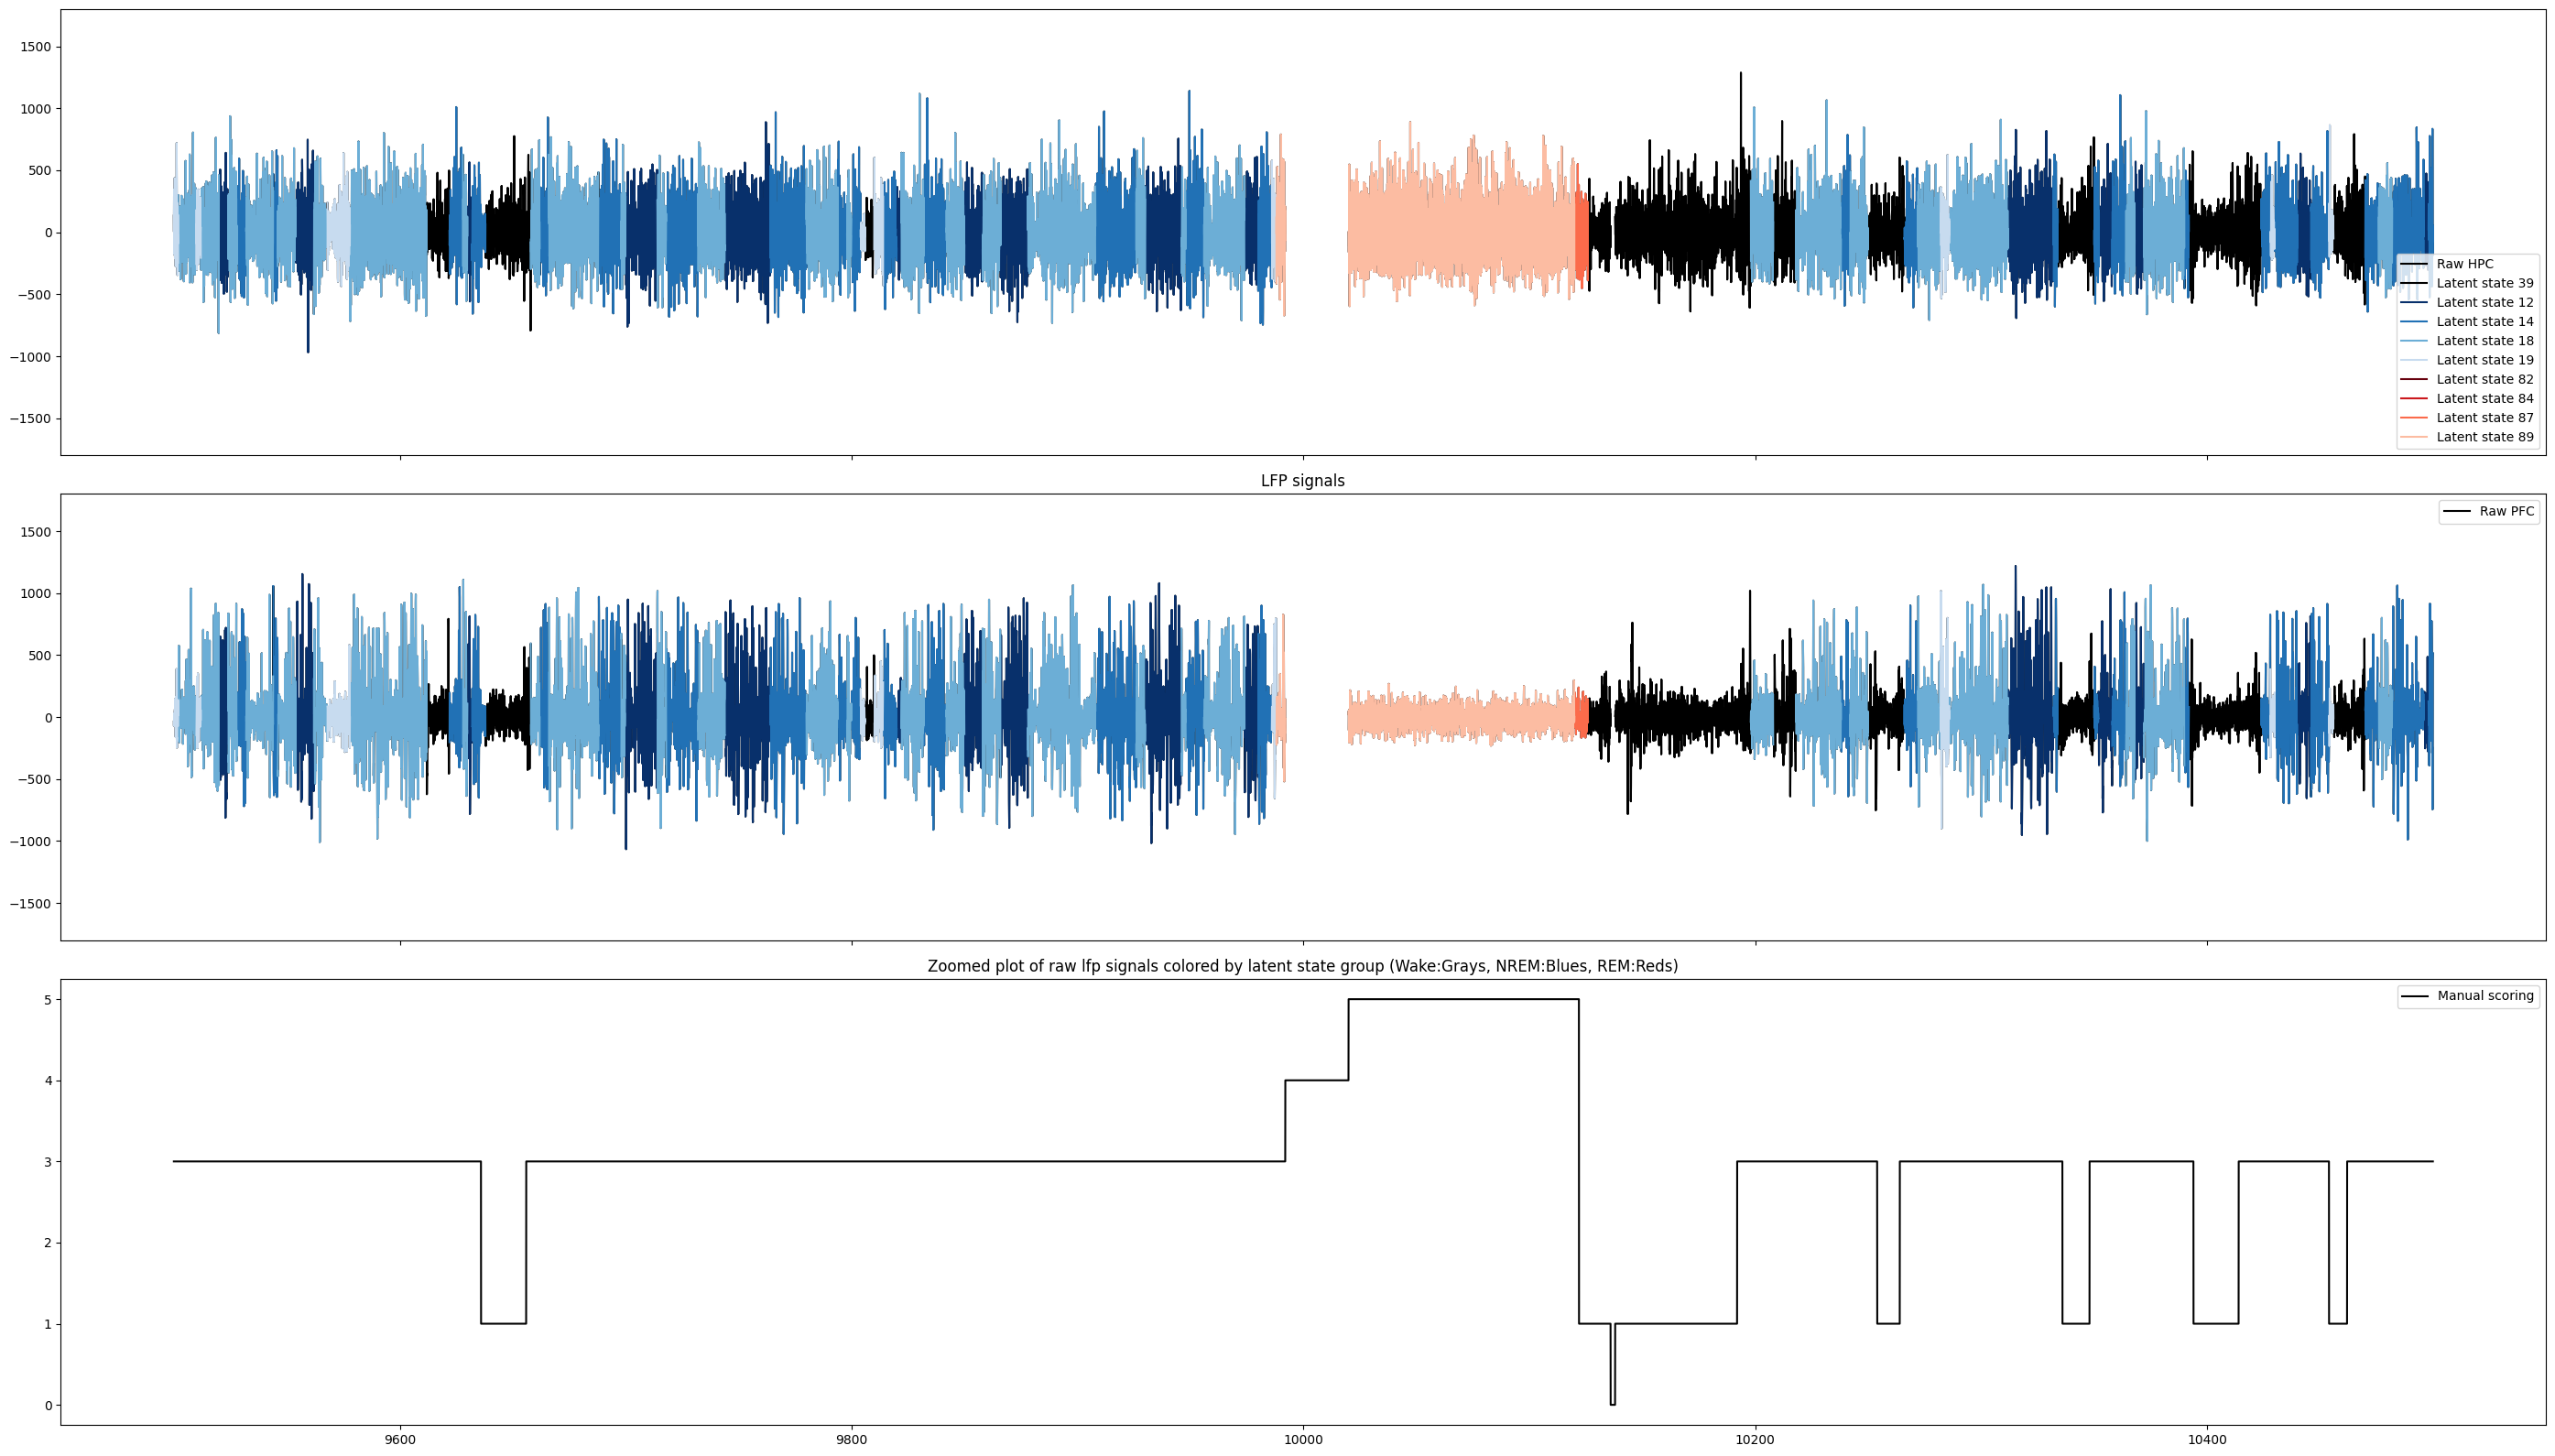

In [48]:
#@title Zoomed posttrial plot 2

x = np.arange(len(raw_hpc))/new_fs
times = np.arange(9500*new_fs, 10500*new_fs)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (28, 16))                                           # Plot whole LFP signals and manual scores to get an overall view of target areas - cf zoom on these areas below

# Plot data on each subplot

# Base signal
ax1.plot(x[times], raw_hpc[times], label='Raw HPC', color = 'black')
ax2.plot(x[times], raw_pfc[times], label='Raw PFC', color = 'black')

# Wake highlights
cmap = plt.get_cmap("Greys_r")
colors = [cmap(i / len(wake_latent_groups_numbers)) for i in range(len(wake_latent_groups_numbers))]
i = 0
for i, data in enumerate(wake_hpc):
    ax1.plot(x[times], data[times], label=f'Latent state {wake_latent_groups_numbers[i]}', color=colors[i])
for i, data in enumerate(wake_pfc):
    ax2.plot(x[times], data[times], color=colors[i])

# NREM highlights
cmap = plt.get_cmap("Blues_r")
colors = [cmap(i / len(nrem_latent_groups_numbers)) for i in range(len(nrem_latent_groups_numbers))]
i = 0
for i, data in enumerate(nrem_hpc):
    ax1.plot(x[times], data[times], label=f'Latent state {nrem_latent_groups_numbers[i]}', color=colors[i])
for i, data in enumerate(nrem_pfc):
    ax2.plot(x[times], data[times], color=colors[i])

# REM highlights
cmap = plt.get_cmap("Reds_r")
colors = [cmap(i / len(rem_latent_groups_numbers)) for i in range(len(rem_latent_groups_numbers))]
i = 0
for i, data in enumerate(rem_hpc):
    ax1.plot(x[times], data[times], label=f'Latent state {rem_latent_groups_numbers[i]}', color=colors[i])
for i, data in enumerate(rem_pfc):
    ax2.plot(x[times], data[times], color=colors[i])


ax3.plot(x[times], upsampled_latent_states[:,1][times], label='Manual scoring', color = 'black')


ax2.set_title('LFP signals')
ax3.set_title('Manual scores')
# Add legends
ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_ylim([-1800, 1800])  # Adjust the range as needed for HPC
ax2.set_ylim([-1800, 1800])

# Adjust layout to avoid overlap
plt.title('Zoomed plot of raw lfp signals colored by latent state group (Wake:Grays, NREM:Blues, REM:Reds)')
plt.tight_layout()
#plt.savefig('FullLFPs', format='pdf')

# Show the plots
plt.show()

# Blank spaces are either artefacts or manually scored as TS (transition state) (both scored as 0 here)